<a id="Top"></a>
---
---
                                   ___                                     ___           ___     
        _____                     /\__\                                   /\  \         /\__\    
       /::\  \       ___         /:/ _/_       ___           ___         /::\  \       /:/ _/_   
      /:/\:\  \     /\__\       /:/ /\  \     /\__\         /\__\       /:/\:\__\     /:/ /\__\  
     /:/  \:\__\   /:/__/      /:/ /::\  \   /:/__/        /:/  /      /:/ /:/  /    /:/ /:/ _/_ 
    /:/__/ \:|__| /::\  \     /:/__\/\:\__\ /::\  \       /:/__/      /:/_/:/__/___ /:/_/:/ /\__\
    \:\  \ /:/  / \/\:\  \__  \:\  \ /:/  / \/\:\  \__   /::\  \      \:\/:::::/  / \:\/:/ /:/  /
     \:\  /:/  /   ~~\:\/\__\  \:\  /:/  /   ~~\:\/\__\ /:/\:\  \      \::/~~/~~~~   \::/_/:/  / 
      \:\/:/  /       \::/  /   \:\/:/  /       \::/  / \/__\:\  \      \:\~~\        \:\/:/  /  
       \::/  /        /:/  /     \::/  /        /:/  /       \:\__\      \:\__\        \::/  /   
        \/__/         \/__/       \/__/         \/__/         \/__/       \/__/         \/__/    
---

#### December 2016


### Table of contents

* [Build prediction models with tflearn and tensorflow](#TF)
    * [Softmax regression model](#SR)
    * [Multilayer convolutional neural network](#CNN)
    * [Serialize trained CNN model for serving](#Serialize)

* [Classify digit examples from Digitre](#Digitre)

In [3]:
# Standard library
import datetime

# Third party libraries
from PIL import Image
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data

import prep_digit_image as prep

In [5]:
import imp
imp.reload(prep)

<module 'prep_digit_image' from '/home/luis/Documents/digitre/digitre/prep_digit_image.py'>

In [6]:
# Latest update
str(datetime.datetime.now())

'2017-01-02 18:02:22.694660'

In [7]:
def print_elapsed_time(t0):
    """
    Given a start time (time.time() object), computes and prints elapsed time.
    
    Keyword arguments
    ~~~~~~~~~~~~~~~~~
    :param t0: output of time.time()
            Start time to compute elapsed time from (no default)
    :return: Elapsed time as string
    """
    elapsed_time = time.time() - t0

    if elapsed_time < 60:
        print("{:2.1f} sec.".format(elapsed_time))
    elif 60 < elapsed_time < 3600:
        print("{:2.1f} min.".format(elapsed_time / 60))
    else:
        print("{:2.1f} hr.".format(elapsed_time / 3600))

<a id="TF"></a>
# Build prediction model with tflearn and tensorflow

<a id="CNN"></a>
## Multilayer convolutional neural netwrok

Code based on this tflearn [example](https://github.com/tflearn/tflearn/blob/master/examples/images/convnet_mnist.py), with CNN architecture modeled after TensorFlow's tutorial [Deep MNIST for experts](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/).

In [8]:
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.estimator import regression

In [41]:
# Data loading and preprocessing
import tflearn.datasets.mnist as mnist
X, Y, testX, testY = mnist.load_data(one_hot=True)
X = X.reshape([-1, 28, 28, 1])
testX = testX.reshape([-1, 28, 28, 1])

Extracting mnist/train-images-idx3-ubyte.gz


/home/luis/anaconda3/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
/home/luis/anaconda3/lib/python3.5/site-packages/tflearn/datasets/mnist.py:52: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


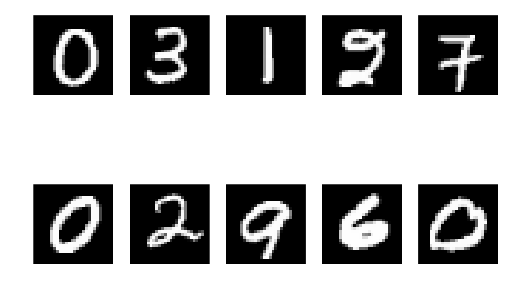

In [42]:
# Plot a few training examples
X_eg = X[10:20,:,:,:]

X_eg = [digit.reshape(28, 28) for digit in X_eg]

for i, digit in enumerate(X_eg):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [26]:
### Building convolutional cnn
cnn = input_data(shape=[None, 28, 28, 1], name='input')
# 1st convolutional layer:
# Convolution computing 32 features for each 5x5 patch
# Stride of one and zero-padded convolutions (defaults)
cnn = conv_2d(cnn, 32, 5, activation='relu', regularizer="L2")
# Max pooling over 2x2 blocks
cnn = max_pool_2d(cnn, 2)
cnn = local_response_normalization(cnn)
# 2nd convolutional layer:
# Convolution computing 64 features for each 5x5 patch
cnn = conv_2d(cnn, 64, 5, activation='relu', regularizer="L2")
cnn = max_pool_2d(cnn, 2)
cnn = local_response_normalization(cnn)
# Fully connected layer
cnn = fully_connected(cnn, 1024, activation='relu')
cnn = dropout(cnn, 0.5)
cnn = fully_connected(cnn, 10, activation='softmax')
cnn = regression(cnn, optimizer='adam', learning_rate=0.01,
                 loss='categorical_crossentropy', name='target')

With latest stable TensorFlow version (0.12) throws "`ValueError: No variables to save`".

Needed to revert TF back to **version 0.11** for this to work:
```
$ pip uninstall protobuf
$ pip uninstall tensorflow

# Ubuntu/Linux 64-bit, CPU only, Python 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/linux/cpu/tensorflow-0.11.0rc1-cp35-cp35m-linux_x86_64.whl
# Mac OS X, CPU only, Python 3.4 or 3.5:
$ export TF_BINARY_URL=https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-0.11.0rc1-py3-none-any.whl

$ pip install $TF_BINARY_URL
```

In [ ]:
# Visualization
# Used "tensorboard_verbose=0", meaning Loss & Metric
# Run "$ tensorboard --logdir='/tmp/tflearn_logs'"

<a id="Digitre"></a>
# Classify digit examples from Digitre

In [14]:
# Example digits collected from Digitre
b64_0 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAATSElEQVR4nO2debTdVXXHPy8EkhdISCCUYclQhqRQCqEyRJAiEhkUxIUFZOgSFaLSAoKgQgeRWqko2LpaJkGshYKgaAs4QXiZzBwMmQAZIoEM5GWek5f3bv/Y7673u/f9hnOn37n39/t+1tprJXd4b79zzv6dc/bZZ28QQgghhBBCCCGEEEIIIYQQQgghhBBCCCFag0FAOzC4V4r/bw+8Xvz3IE86CpEKhwEfBv4R+AHwE+BXwPJe6QTeA7YGZCXwTq9MBx4PyAPA/cB3gB8BNwGfBy4GjgRGArsFpK3Rf6AQldAOfAT4FjAPeAUoxEjRKOI+EyW/D/x7U6+sBzZgxrUIeAT4J+BvgPOBoY3704WI5njgSWAmlQ3yWgxkVoWfXw2s6JVfA3cCN2AGPbD+TSLyzm7AJ4FJ2HKpACwmPQOZUuX3gjIXWIst854GbgbORgYjamAv4HLgRaCL0gE3icoGaC0G8kKV3yvKZmxWKX99LTbL/AT4NHBSfZpN5IGTgclED7pOYEvM+/U0kI4qv1eU1ZiRJH1uBWaM47GlpBD9aAf+GVhC8oCa5vCZehjIb6r8XlHmVvGdZdhe6wxgRE0tKjLDWOBZ3AfR1Ao+W4uBzKjye0X5bQ3fndT7+78EHFN904pWZyzwS2A77oNnPcnu3XoYyPQqv1eUuKVinGyidPZZBvwrcFyVbSxalIvo28hWMisUgAkJ7/f0/tw/YpvirhBJ+h1/qFCnoKwE1lT53QWE77PWAd8HDqqirUWLcR2lT/b1VHbGERxEL2NnFndiRndOr5yBecQOB0aXyaheGQ0cBZwFnAdci52e3wY8CDwKPA/M6ZX5uBnXKmBbBX9PJcb/KvBt4OiKW100PcOA2wl/Qq7GBqHLIFqIhYZ8CjiwBn0+CFwPPIMt2zqAgyM+2wa8HzgN+BAW4jIeC02ZTl/4StGAqzGOdYGf4fKQuBxzcIgMMAS4B1v+RHX6HOzpG/X+bOAybKBWywDg49g5RCelS6k4A3H5uX8FXIBtrh/DDjgr2QNNrOCz3djS9D+xthUtTBtwFzYAkzbkU7GNavC1GdjTclgNOuwB3Ip5zLoDPzvobarFQMIYhC31rsAG8ltEn+NsozT+K0mm0bfcmwacWke9RYq0YTNHsWMnk2wkM4GNWGDgvwD71/D7dwfGYaEjW+jvXXqdvlmt3gZSTnGW+Xts5go+CObjbhwLMO9W8LU3gI81UHfRIG6jfwdPBnaEvB6UF7C1fi2ciR347Qz83LmUbqB7gDdJx0CCtAHnYi7clZgzwMU4NhN9RrML+NuU9Bd1og24g/6d2UG0kbyEnZFUy2nAQ4THQu2i/xlHcZmVpoEEGYiFy7ucvUwlfh/XhT2URAsxALs3ETaTlC+3fgoMr/L3tAHXYHc1Job8vqLMonQWeQ0bdL4MpMgwzO38COFxXCuwJWGSEe0E7k5Zd1EjA4BvEG8kDwJ7V/nzj8PimIpP12VEe8R6KF2m9GCHir4NJMjJ2Ma+OAv2AL/DbRn2S2xP8+XUtRY10Ua4kXRgG/lqjeNYwkM74gbUFEpnr+dpLgMp8peY520ayfu2AnZZa33vvzcBn01fZVELYcutu6jelz+W8L1GATOARRHv7aD0UtSrmJE1m4GALb1uJPrvDBpH+dJsK+bFEy3EAPo27vdQffKDM7FYq7hBM4/oJ+8szIheB26hNsdAGpxO9KWx4MxRLsvQXZOWow3ztlRrHKfjHhAYFQz5EvZkPqDaP8IDh2FhNkkzR7k8g11jFjngCGy/4HJjr4Cdc2wI/H8JFpjYqllIDsNCWXZhG/KomaNcvuBBV5Eyw7AN6wZsiRQc+HEyBYuN+joWydvqtGG5u1yNo9D72Q+lr6pIi72wJ2ew0+eSPEi6MU/Q6PRVbigjsaBLVwPZgiXWU1aVDDIY20iHdfwCogP91mDZQ7LKQcD/kWwcc7C7M93A17xoKhrKJZRG4ZbLavqHaszBommzzoGYmzqsXd7GlpfBtluMBU2KjHAqFg6S9JTciHmsurFZJU8h4J+g9LLVRmyv9gbhbfUM1Yf0iCZiGJVdJFqPRQLnYeYo5y6sDWbilnboH/yoKepFO3Af7sZRwJ6Yp/lQtgnYA3P7xt3KLH+YXOhFU1EXvkBlxlFAsUen0/9GZpxMR5lSWpJxuGVaDMo3ad3Dv3pyN8lt1Y0tXXuw7C3VBooKDxyBReJWkrztZ9R2Zz1L7Ed8ZpXX6H8r8TNeNBUV0wZ8D+u0DZiLMimkZBHwZz6UbWIuIDw31+tYAGf561OxsybRxLRhHbuR0s5bjOXCCjOO5eTTY5VE2FXnmVjuragHje6zNzlHER2h+wq25Cq/jz3ei6atwfuwSN91mOs76WrALCycRzQhI4CniO/AtdilpmJuqXtR0rQk/pzKEmlf5EdNkcRNuHfiHKwClTwvblyDe9v+uycdRQzHUJlL93XsrrZwYyDwHNHtuRHb53Vgrt/dvWgpQtmHyqs53exF09bmcvrarwvLSzylV1YG3tuO7ow0FTdQmXE8DuzpRdPWZih2n30ytkSN27Bf4klHUcYpuKf7L2DJB/7Ui6bZ4Gnc2llJ55qAvTEXpKtxLMfSc4rquRW3tn7Gl4Kijy8Sn2O2XL7vR81McRlubf0sVrpBeOIUohO6Rbl1a6kkJYwjcGvv91DYiTd2x55Qk4kOHwnKduy2nKidg3GbtTuRgXhjHH31Ojqx8JFOojvrYZTwrF4cAryLzRBxshIZiBeOxLIZBg1gJxZ6Hbbkmoslphb14TgsucWWBNmMioN64XaiZ4r1lB5adQOf9KJldjkWtyXWKjSDpM6puGUBXIHtTx5DnpR6cyzum3TNICnzC9y9VvOorXCnCOcY3Nr/eTSDpMoXcSv+UlxaXeVFy+zzd7j1wf/6UjCPHE5pMFyS/A49vRpFsBx3nDzkS8G8MQT4D9yNYzlWFEc0hv/BrR9U2zAlLsTdOArAt/yomQuGYNG8s0kOED3bk4654iDc0l8WZT6K1G0ko7CCO8WZehl2OaoDeIu+w9qtwNF+VMwXP6Sy2eNSP2rmhiuIbvsezHO4ADMY1Q9pMB/AspB04Hb28TNgXy+a5ofbkQerKWijtOrRy9gUHtUh72DpaURjmYabgXzFl4J54SosAjfY6G9iWcd3lb3eDXzJi5b54hCiC+yUy1medMwF+2Cb7ajGn0dp2svn0Ho3DQ7HzTg2kK+iQ6lzNcmdsBPznixEZcDS4tO4GcjrwABPOmaeEbjfEuwB7vejZi65E7d++ZEn/XLBtbi7dFeTjVrlrUJ56ewo+bovBbPOUNxreXRhoQxtXjTNHyOw6wPLib+5WQA+6knHzPPXuM8eU9AV2jQ5GPMW7sA24ZOwh9lMrC82YfvCHVh2fVFn9sQ9v1UXytqXNlcR3ydLsHvqk9GDqyGMorRIfZx0ILdu2nwXt7551peCWcfVQ9KNJVAW6dGGe9b8Gz3pmGkOxcKnXTrgbVRkM23G4hYLtxP4mCcdM83lWIyPS+H6OzzpmGe+idvDaz26xdkQHqVv8z0Dq5Qa5kpcBpzkSce8sjfmqXIxkCfQCXrdOQyL1C1v7A2YobyELau0AfTDV4mvaBsUVbdtAOcQ3+ibgKWYr125ddNlCHbWMQ3bI8Yli3sT20uKOlNcXiXJLCzlqEiPz9PX/luxpdZ0bHYv758nPemYaYbhXhnqx550zCuHEn5BrQczlJn0nVt1Aef6UTPbXIglOHYxELkP0+UrxPfHDuD32Mn5BFTRtiHch5txvIwKbqbJUSQHJBZlDbpe2xDasQTTLp1wrycd88rDuPVLAXOeDPWjZra5GFu7JnXAFuDjnnTMI2fjnv+4AJznR83s81+4dcASXwrmkHbgV1Q2ewzxomnGGYlt7lw64R5POuaRm4hPlhGULqwMnmgAx+PWCT3YQaJoPEdgYT6d2GWoxcT3zSN+1MwHrsFvr2A32UTjuZfStp+PnXWE7UfWA3/hR83scwB2Ku5iIE950jFvRJ1H9WB1VpaXvX67Fy1zwsnEpxANypWedMwTh2JLqrh+6MQ25JuBN7AMi6JBXI9t0KcQvyHcBBzoScc8cRfuXqvZqKxdwwkmpF6BZUachKXMXxt47xl0ANVozsceRK4G8gRKs9RQ9iM+79VC7A7IFOAGTzrmhUNwz9RewIJKP+BF0xwxCrfO2IzuFjSa+3E3jgJwnR8188VNuHXGG8AgTzrmgUtxj6IuYCUnlCgjBX6BW4fch+42N4qjcc8gU8BqtHzYi6Y5YzSlNT3i5GpPOmadP8HK1L2G7fVc+uIWtDFPhRNw65ANwGmedMw6X6OvnXsw72HcvQ8trVLkRtwMZKkvBTPOaCxtUnl7/4Hw86h3UJWoVPk5bgbyb74UzDBHklwAtYPSmpDXetE0x7iGl+jueX0ZifsNwZnYLPMEuuKcKqNwS368Bjjdk45ZxaXeY1BmA2O8aJpjxuF2vXYhdtou6sNY3NMqFbDrzWd60TTnXIlbB831pWAGGYl7QaKifAe5dL3wDdw66DFfCmaMAVghzUqM47fYXR2RMgOwTZ9LJ433pGPWuAy3JW1waXuiF00Fu2MRvF3Arl6J6qiTPemYJU4h+QJUULqAz3nRVACwLxYYNx3zkCzAwqyL1VFnYHcS1qPk1LUyAngBO2ydiW26kwzkcZQ21CsHE582v4Cd5s4G9vGkYxYYiW2yi226DLtPHlc6bTK6PuudU0k2kAKWwWQPTzpmgcsIb9fFwKKQ13cAH/GiqSjB9aDqUTTVV8s4YCXRbbsBW84WZ5Nu4Gbk0m0KvoqbgShBdXWMwfZ1Se27E1tSrcHyAmi2bhLuwc1A7valYAvzPtzvdRRlHnCsD2VFOA/h1nE3+1KwRRkMPE9lxrEW3bVpKgZh6XuSOq4H5VuqhD2oLAt7cVN+mw9lRTTtuN1/7kbTvisDsTszxfqArqIa5k3IIKyOnQykPuyB7ekqCSMpYJehRnrQVyTQDryLDKQe7Imdem+lMuNYCJzkQV/hQCUGonsg0eyNOTvWY1G3rsurNcBZHvQVjgwmPFGADMSd/bFUPcW22oAZSVJ0QhdW1kA0MYOBbSQbyC60Rg5jP8IzjmzD9hVRRtKNRegqMqHJaQcmYp0ZJxOA4X5UbFrGYMGGcW7bMCPpxvJfKXVrCzAEt03lOmQgQU7AIpyT2m0bpXuSLuDLmCtYtADtxAfRyUBKOQA7MF2Ku5equCfZirmAd0tbaVE9Q3AzkE2opPABVF6SoCgbMRewAhBbjEGE30UIk/M86dgMfJD4/UaSXI8SvbUsP8Wtk8/3paBH9gWuwZaY1RjGu5hxDE5bcVE/HsWts/MWzXs0tiyaQnXGsQIrhCNanDtx6/CnfSmYMu2Yp6m49NxJ5curJegQMDNciFunv022kza0YTFRYeH/i4D3Ql4Pk4XAuSnrLhrIGJJjhxZhh4Wf8aRjoxmKZZeMiyqYkfB+Act3dXzKuosGMwR4k/6dvRI7ZZ9N38B40o+KDWM34BJsCRWXMK+AtUFUwredwINYXJbIIN/FOno7ZhCTgeX0HwjbgSs86VhPBgDnYAd4O3HfW7xF/3OjLcBF6HQ803wWmy3mkxyFOpPWLVjfhtU3eZjKDCMo07E4qwIWa6UyaDlgMOFRqXHr8Su9aFodRcN4AIsK6KA64yhgZyLTsCWVIpxzxHjcBkg3tgRbBVxH80elngj8N6XXYNfiFmITJguw+oBK6pYz9gdeJXmAdFA62J4Ezgb2Sl/lSA4FPgX8BkvMHbVUqtQ4HsByGYuccjHxA2Q24UuxHiwH1C1YPtm0jaUNu7x0NfAD4I8hOpbLKuAlh88VsL/5HCz0ROSYAUSXg16KJbAOe28nfYOyG3s6TwC+h52djAEOxGapA7HT6jDZK+a9dswlPQI7azgB+ATmgXsKCyufQ2Wb76lAZ8z77wF3kO0DUlEho+mfLnMZNviiBtI0ws8RJtN3CNmDLc3WYeHfW0NkYsTrRXkRO9FfHaHHVtyq9ZbPimEz4q+B99fWlCKrnEipQSTll40K6JsQ8tp2om8xTkz4PWE/L8woKzGQmfRF63ZjBnMpze98EJ4Zg629k/LLbiN6cx928txoA6nEXV00isnYZv4WFJouKuCjJG9k3yI6RilsudNoA9mEuXFdDWQNdnA4tj5NJvLGcOwcIWqARYWCdwLvhLzeaAMpYPXcXQzpQezehxA1MRw7VyjfqPcQnds3aqmThoHE/ZylmHdNM4aoO6OBW+nLxrgQc6+GDcQor1caBrKA/jFlc7F8VMfUu1GEKOdwrCjlFPoC98olanOfhoH0YI6DlcAPgQtQ6lThgYHYIdoVwI8xl2lPr7xI+gayEXgWKxf3OexgUYimYTgWjnEZ8G0s7OM5rO7eql7Zgm2QqzkonND73ZXYqf7PMQfCjcAZ2Am7itCIliMYKjKE6kNN9sTOKdrRQZ4QQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQuSG/wddk48Q+RXfLwAAAABJRU5ErkJggg=="
b64_1 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAIdklEQVR4nO3df6hfdR3H8efdde7ey0ZGP6DQbSSUZIIEKf3AMKcwMBMqaJFLIbACaaX0V0KQa2Y/bJFiJQQpgUbLtUbqZd67uTkli8mm5o/sh80fm9O263Z12723Pz73y/3+ON/v+Xjvd3vfe8/zAR/udjfO9/2F8+Kcz/l8zucDkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJktRdi4DFQF90IdJsMQBcCtwDPAIMAXuB3wLnBNYlhVsJDALPAxOTbajuz/uAK8KqkwJdBxwjBWErxQGpheTioBqlk+7DwEZgnKkQvAA8RXFAJki3W9K8djZwJ/AqKQz1V40JYAvtA7IXO+6ap94P3EgKRu2EHwSOAtvqfjcKvA78ixSW5rb4JNctnXArgE20XhH+RgrEcRpvtdq1I0D/Sa5dOmF6gauA/wIPA2M0nvDHSSEpCsMYKRD17RAGRPNEL/BDGk/6bbQGYUvB7yZIV5TDTc2AaF74ILCB1pP+KLCz6XePkfocZbdX3mJpXvgirSGob88A/677+3HS7ZcB0bx3KSkAQ3TudD9BY3/kgQ7/14BozusBVpFO/NrJvIPOJ/tw3Z+fLPm/BkRzVi+whtYrRu3JVbuTfYQ0KfFl4CbgIGmMpKwZEM0ZPcD1tA/B06QAtPv3naTbsrNJ/ZLmx7rN7T+kWb/SrNcLfIfy26JHSVNEmh/h3gEsnzzWx5masNipvUQKpTSrLQA2k9dvqF0pagEYA66l8UT/aOZxDIhmvQXAzaQT9j7yQ7KdNDnx8oJj5gZkFwZEs9gCYD2NJ+395AdkZZvjfj3zGL8+Ad9J6ooe4BaKT9zBNr+vD9FZHY7dHLp27Udd/k5SVyykfTjKQvJ74NyS499Tcuxa+0YXv5PUFb3AOopfYCq6UtT//XfAKSXH7wN2Zxx7Al+51SzTC9xAOjnHaRz9btdqHff15HWozyBNYiw77hiwtCvfSuqCU4C1NJ6kuSHZTApXjlWkCYtlx9wNvGfG30rqgh7S9I9hWk/UcTrfbt1MetqVax3wEOnd9CHSZMf/FRz3vpl9Jak7eoCfMHVibqN1nlW7K8l63lo4oHUm7xukkffarOAdpNH4tdP/SlL3bKT1xN9OeUhu4a2Ho5fGxeLatWeBL0z/K0ndcS1pxmzzUjwTwIMUh2SIFI7pjHBfCOwv+Kzmtp/0lqIUZgVpxuwEad5U0UtMRVeSdaRxkulYXfAZRe2laR5f6prbaDwpj1Hcz6hfeOEG8p9WFfl+wfGLmisqKtQiigfrjlJ8uzVM6jTPJByLgbsKjl3U1szgc6QZW0KaKnJ/QRtkar3cWruJ8hHyMqcBB8gLyMdm+FnSjCwh9TnatSHgNdLJeivdmXJ+JnnheAX3B9EssLSknUkarOvW+xhXkheQHcC7u/SZ0pzxY/ICsimqQClSUee/qF0fVaAU5SzaL1rdPBD5maAapTDnkTeDd4z0tEuqlMvIu73ajQvFqYK+TV5Abmf601ikOete8gJyXVSBUpS3kwKyi87Lkk4Anw+qUQrzAabW2X0OeJw0S/gh4O+Tvz9MGkG/IKhGKcz5dH6sO0rqnG9g5vO9pDnnS+T1P+7GPdFVQbeSF5DvRRUoRRomLyBXBNUnhekh7SSVE5CLgmqUwryP4jWvmtsB0nQUqVJWkZ5SlQXkYaZ2n5Iq41vk3V5tiSpQivQb8gLy86gCpUibyAvINVEFSlGW0bimVrv2JvCpoBqlMOeQ5l6VBWQUF2lQBZ1H67Kl7a4gpwbVKIW5gLz+xxP4kpQq6LPkBeTPOItXFfRN8gLyUwyIKqaXtDVbTkBcqFqV00v+QnEXBtUohVlI2kYtJyCfDKpRCrOM9B7IX4F/AP+c/Pnc5M9aOMaBj8SUKMU5n7Rj1QRpG4VXSfsOHiBtr1bb0faPwLlBNUphLiLv9mo7ad1eqVIuJi8gg1EFSpEuJy8gm6MKlCJdQ15AfhFVoBTpRvJH0aXKuZO8gPiilCqnB9hJXkBWB9Uohekhf7s1l/pR5fRQvs1BLSCnB9UohVkI7KM8IGP4qq0q6DTgRcoD8hrwzqAapTCXkOZclQVkH/COoBqlMLmv2u4C3hVUoxRmFXkB+QNp/0KpUq4mLyC3RRUoRVpDXkBcj1eV9DPgMeBJ4C+kvsYbk60+IN8Nqk8KVVvNZIz0NOsgMDL58wVgD/AAsDaqQCnSHeTdYn01qkAp0l3kBeTTUQVKke7GgEiFFpDGN3ICcllQjVKYAeBx8gKyMqhGKcwi4Hm8xZIKDZAWhisLx+vAiqAapTD95AXkIM7DUgUNAEcwIFKh3IAcAt4WVKMU5nTSviBDJW2YdDsmVcpyplZ179RGgL6YEqU4y8kLyMt4BVEFLSNvDMSAqJI+RF5AnsaAqIK+TF5A/hRVoBTpaxgQqa3bSY95HwQeJW3aOQocpTEgv4wqUIr0K1rnXI2QdrbdSdqTcCsGRBW1mbxbrKujCpSi9AH3kheQzwXVKIXpI2/R6gngjKAapTD95C1afQxYGlSjFKYf2J/R9gLvDapRCtNPmsZ+pKQdwlF0VVA/ee+CHMaAqIJqnfRDJe1FnOquCuonDQqOlrQRvIKogrzFkjpYTPmrtrW2OKhGKYxXEKkDH/NKHXwCeIU0g7dTQPbjUyxV0FeAp0h9jEdof7u1BwOiCtrAVAjGgWdIYdkDvFn3bxujCpSi9JE27Cy6YoyT3izcCjwLrA6qUQrTT1rKp1PfY4Q0UfGSoBqlMAOkAJQ9wXIUXZWUu2i1YyCqpCU4ii615RVE6mAR8IPMdmpQjZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkSZIkaeb+D1OvJCSrcNezAAAAAElFTkSuQmCC"
b64_2 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAPaElEQVR4nO3deZCcRRnH8W9IstkkQJAjhHAELQ5FUQiIIpSioSIiclggIEchaBUCWkgVlIqIIKIQQKKU4RKkREsoQa6EIuTY3VzkApIQrhwgBHKRkGOPhL3845nXeeed7nfeyc7My+77+1R17e67uzM9U/1Md799gYiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiEjmDQLqgaG5rzulmx2R6hsEDM6lfYC9gZHAaOAHwO3Ao8Ak4DmgBZgMrAUmAg8D5wNH1zrjItUwCPgmcCNWwCdihX0zsAFoB7qA7tzXhtz34TQ58vNs4APgIeCrNXslIhXSD/uEfxIrzO0UF/rNQKvj+nTHteciPzeFvt8O3A0cUpNXJtIDw4GLgf8AW4BmYCHFBT4uQJoc18IB0g68Hfn9MmA+cEbVX6HIDhgN/BZYQXHhnuq4FhcgbzmuhQPkRaAz9PNHWIB0A5uA86r8WkUSOxKYALyJOwi6gXXANsd1X4CsAd7DHyANkd9Fa5wtwKlVfM0iJe0O3ARsJF8wXbVHkJY4rvkCpJviJlTQSe+isIZZgdUgrsceXa0XL+LTDzgNd7+i0XEtSLOADpIHSLRWCAJkKfnm1XbgjZj/n4uNn4jUxC5Ycyrc/g+nTVhzyvW7FuAVkgdINNiCAJkeutbgycP00ONeU403QiTqcOBZ/DVEklpkSuTnuACZEfq+AwuQreQ74687/ncV1oEPX1sADKvC+yHyfydQPFDnS69hBd/1u1eBttz3zVj/pQWrddYBi7FBxPuAW4ELgWOAEdiI+5eBG4B3sFu60UCI1lBBurTi74hIzs+wQt2Ge3zClWZ7rq8HHsPuMI3FOvpDcimYepLESVj/Igi0afhroqBZJlJRBwP3U3iH6B1gEaUDZBH5fkon8DxwBdZMq5TjsFpkZoL8fIgFo0hFjME+lV2F7X3sTlJcgWzGCu4jwMlAXZXyeQ7WRCsVIJ3A2VXKg2TIMGxCoe9OVLiGeN3zuzbgHuALNcrzYkce3sPGShqwQG8EbqlRfqSPGov7tqkvLaR4gG4y8I0a5/s28kHQgAXGKkd+761xvqSPGAXcjHVy2/DXDK7UiE0cbAOuo3pNqTiXJMzrMynkTXq5MVgHOlyQ5lA84h3Xtp8OnA4MqHHeA2eVyGOQJmIrEkUSORfrcLsKU5I7Q93YLN0jap3xiJHkF1vFpTUoQCSBOuDn2JQMX2Fajw3qxRW48cCuNc67ywiSBchako+zSEYNwFb4JSlQvikjK7F14/1rnHefkbin0kfTFlSDSIwB2K3OTmxEvFSQdFI8It4AfK3G+S5lBBbMSdLOKeVRPuYGYHObwoV/FqWDZDnWT9kIXA98otYZT2AI8dNMgtSCmljiUAeMw11DJOmMP4dNGPy4UoDIDtsJC45puGuLIEhcv2vGZs7uUfNcl0cBIjvsCvIFJC5Ios2tqdjU8t5AASI7ZAy2sVq4kEzHHyRNua8Pkf7YRjkUIFK2vfBvtdOAP0ieJJ3pIj2hAJGyXYjdeWrAvdOIqya5hfSmi/SEAkTKNgBbtfc0tsipCVhNYYEJ90lupXcGB8AB2GuZmiBpHEQKDMC24pyJrfFoxOYkhYNkHL03OAAOxL3vbzS1ohpEPOqw3dWfwOZZTcUGAW8DBqaYr0o4kGQBorlYUlJ/bHr4FGxbnd7WIXcZhQJEKqwO25ShLziQ0sERBIgmK0rmHEGyAJmCAkQy6CKSBYiW3EomXU6yAJmUVgZF0nQ/dvt6BrZ+ZSV2Sze6iOqutDIokqZ/URgI67CxnjVY4DyPzRy4L60MiqRlIO6DeVzpwpTyKJKaA8jvFh+XuoD9UsqjSGq+Q7La4zW0ebVk0C0kC5DZaWVQJE2+8wmj6Q9pZVAkLUdhEy9LBUc7cEpKeRRJzQ3AS9iisJX4JyxuRVNMJGPqKDyscx12qE8jFjThs9ufSCmPIqk5Ff8O9B3Y+YWzgBeAy1LKo0hq7iVZ53wl1lcRyYxDcZ8g5UqPp5RHkdTcSbLg6ADOTCmPIqn4NMlu7XYDy4BB6WRTJB1Ja49ubCsjkcz4InZnah62C2RccLQBn0knmyK1NxB4Fiv8G7HxjrjTeCekk02RdFxAcRAsxxZCrYtcbwGOTyebIrW3GzZK7qstlmI7lgRLbCdg56KIZMJtlO6QdwLzc6m3nGsi0mNjKdxLuFS6OZ1sitTeKGziYdLgmAN8MpWcitTYAGw7n6TB0Y1tICeSCZdjO9D/l2TBMRHYJ5WcitTYceRv3S4k/g5WN9ZH0YxdyYQ9sVOxwgGwChsY9G3vc1UqORVJwa/x1xSNFK4UDJpWOlZNMuEEigMgmpYAi3LfLwY+m0ZGRWptJMVNK19agU1aPDeVnIqk4DLKu6X7IHacnEifdwSwgeTBsRw4KJWciqTgbpIHxyps+olIJhwPbCZ5gIxLJ5sitTccmEZ5TatRqeRUJAW/wrYLnQe8SnxwbMCOOhDJhIMonMa+Adtjdy3uANHxaZIZA4FHcAfCauwsj02ha29jd7pEMuEXxO9K0oGtDJyT+7ufppNNkdoLz9QtlTqAp7A16SJ93kisQ570rtV24ORUcipSY8Px9zt86XZsZaFInzYMuIvyguMd7IhnkT5tZ+AvlDda3g6cnUZmRWppGLYAqhXre7SQfDqJZupKn/cT8oV+G3YsWqkgaQBGpJBXkZq6DOtHhAt/K3ZmoC9I1gBfSiOzIrV0FnY2oCsItmIDgNEg2Yj6HZIBJ1Jcc5QKkq3AtWlkVqSW9sPmTSXpiG/FmlsrsY68SJ82HOtglzPW8SbwR3THSlLQHxgM1GNjEYNLpPoePNcw4AHKC44O4GF0jofUwE7A54DTgN9jE/yewdZWbMUOl2l1pPVYP2AttgfuxFwahx2AeQKlN2XbCbiX0v2OaPo7Cg6psmOBH2HLVlvxF8YpnutbY/5vCTbVfA7wD+BUrKYJ6wdcgo18L8H2q0oSHE8Bh1TubRDJGwCcgtUQwV2gWcAWKhcg2yleAtuFbSL9NHBkLi9jsOAI/mYZFlBxwTEFOLSyb4mINaGuxZpCHRQX9LlULkBWYQERvb4SaAY+xGoV1zryFViN5qpN5gNHV/qNkWw7BBgPvIa70AapIeZ35QbIrDIfx5XmUDhY2IYtlhKpiEHANRRubPAm/gK5ACvwlQiQ6Y5rHcC7Mc/vSm9gfZNW4LzKvj2SZaOxrf6jBW4q/lokWMddiQBZkPBakvQucEtl3x7JsuPwN3E2Yrt++AqjbxO2cgKkGXf/YVHM88alB9CqQKmQY7G+RlyBc9UsQVqGu5lVToCspXjHkeUU3q1Kmp4E9q7oOySZ9T1K3yINPsl9O6G3U3g3qzOXpuIfKNyQ+5ug6Tbb8bi+o8/i0jLg4Iq+Q5JZ+2EFcxrx4xlBmum53ox1sG/AAu4g7My/PfFPMdkrl/bFpqnfATyK1SQ7UmsEqQU4p5JvkmTXn7FC1QE0UXrV3Uvkx0K6sBriRuDzFcpPP+APxG/uliRtRDsiSg+dRuE2m93YNPC4zZy7sLtKj2Gj6nUVzM8IbBJhXHD4bidHUysWvMdUMH+SIf2xyYGuwvUWdkZ49PqHWAE+sQr5ORx4wpOfctN28luHLkCHbcoO+Arxhew9CnciXE31dho8CvcA4Y6kFRR39hvo2ZR6yaAJlC5snVjn/W1s+nk1jMWaQpUIjoXY8cyu3z2D7ewuUtIgYAbJCt37wPlVyEN/bKOEt7BOf9L8+PoiL1L6nPMJKEgkgXpsZu6mEmkzcGkVnr8fcDWFhfcj4GWSBccU7AZDU+7nmSTfGO5+KntjQfqgwdgncFuJtBUYUuHn3g34E+7Cuxxb9xFXwB8Fdsk9VjBvrLnE/0TTeFSTSIzBxK8CDFIrxSv5euJIYFKJ51yKf+bwHcCukcc8luRnfnRjt6lnYRs2iDjVY3eltpRIq6nc3Z/zSH6q7FysyRX8vA64inzNEXUmNnWl1ON2ku/rbEPHOotHPfAB7jlSQWrO/c1JPXyu/sAPsc5+A8UrEn1pFlagVwPnJniei7Bb03E1R1Pk2jbsSDaRAvX42/qt2Cd4Ezat5BXgx/g/vV12xqae3AQ8S+EneLSQxqVJ2G3gpK70PE4X7omQ3VhNdXUZzyEZ8RT5QrIdW4HXhAXHduzTNXxX6d/A12Merz9W24zHpqt04Z7YuBxb6VcqOKYDnyrzNQ0Fros8TrhZ5UttaNWhRFyEFdZGLDiiqwVd6zhewMYSTgH2AfbHTmL6DVago80n37njK4jvMzyKzQbeEUOB6ym/xmpDZxJKyFhsbpWrsMzDPegWXjOyhfxExw7c60k+wD/xcR7Fa0u2Y7OLh/fwtQ3Dmne+1ZG+tBSbdi8CwN8oLiSbcG/jM4fCWmYbhbeKfWvS4wb/GskHSTt26E2lDAXujHlu1+tuyL1ObQ8kgG3rE73z42pabaS43xANkA7cgTXdcS2cpmG1zOlVeH37Aw+WeP7g9c0k30ScARxWhfxIL3Qq+f7ALNxNK9dkwmiABM2m6N+V6gPMx/o01TIS+GvM878ck28FiQDwLWzG7gsUF5TF2ITCJAHSSfE6kvUUDvqF/38CsHv1Xx57A4878jAX28nRFzwzUHNLck7CmiPRu1m+zRxcARIUuvDPGyje9G02tT/y7CDyzcdgY2zfXbZwmkl1ZjNLL1QPnEG+Yz0T//JXX4B0Utwxn4O17xuAC6js/K5yjMJqhUbit1INUjANfw3V6SNJL7UHdkZH3MxaX4AEtUgXtv3OA8DvsF3VPw6r+k4hfs19tPYIPiDWARejE6kk5DjgHtwbJfgCpB3r1P+Sno9nVMtY4HXig2MB7v2Ar0ZBIhG7Yn2Ge7CNHtaSn9C4Dpicu34lVvh6QwH6Lu6bD93YxMrlnt91Y9sc7UvxPl/h4+Yko+qwRVT1ua9D6L0r9C6mOEhWE98E68Q6++uxD4jwDOgZua9bUJBIH3Em+eaWb4JlODieJ9/E3Bb5fTApsgUFiPQhY7FaI27WbweFA6YKEMmU7+M/Sq6D4tWQChDJnMOw/bPiag4FiGRaPfBP8sHhO99EASKZVQfcTb5DrgARiajHBjt9Kx8VICLYHKypFC8nVoCI5PQHvg3cjPVJVmGj7RooFIkYiDW/gpkEmmoiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiK9y/8A47Qb+6CCWQYAAAAASUVORK5CYII="
b64_3 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAMiUlEQVR4nO3de4xcZRnH8e/uctlCW0BaBNJCJQWUi2KNGrFGEWhE1DSVcicRRIglIpAgKoigSJWLBlTQgFxULiaEezUp3bK0tFzaYsvSCy1ooRRKW9tuu71ud8Y/njnZM2fOmfPO7s55d2Z+n+TJMmdOl3cm77Pnfd/znvcFERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERkwewFDQtFa+Llv5HhcDE043hrzuhXYI6PPJFLW3sChwMeBk4HLgDuB24EHgUeAR4HHgWeBD0KxBdgKtBd+loukc9aFfk/weh0wA7gJOKJaH1wkrBkYBnwTS4I/APOABcA2IB+KNyKv0+J5h3PaE453AdtDr7cUIni9Crho4L8OEUuK44CfAm3YX+jdpFfmhQ7nZJUgeWAH8LeB/Wqkke2PXSWWADmskvVgzSKXCv9v3BIpqwSZDWwArhzA70ga0BDgGqzZFFcZX0g4Ho21QLfjudVMkBwwK1SWDqyfJFKxU4EXKV9JXROkC9jpeG61EiRX+DzRRL1hYL4uaRRNwCXAu8BLWHs9qZK+V+a9cOwGNjmeW40E2QzMAXbFnN+GDTeLpBqHDcX2kF4R81jyvFnm/XCCLHY4r1oJMg9YUzgejTVYU1KkrNOxIdB5FFe49cBckivqS2XeC0dSP6baCZIvvN6WEFtQgkiKyVgzJA+8QumoTwewgvgKOSvheDRei7zOYVeW7phoJ7lCB5F0TnCjMHovJim2oQSRMk6nNCHaKK1IrxI/VLsmcrynEAuxu9fTgPuAu4EpwIXAucA52F3tI4ADYmKflBiacHxI4edHCmXbnBIfYFNRREp8BniH0kq/ldKmVh6r8LnIsU3AMuA24DvABGB4IXw6gPg+RzQ2owSRGE3YvKgO4GVKk6GD0ivL+sK5PdiV4XxgRNYFd3QGbk2s1dj8MZEiV9PbGd4KPFf4mda/mIU1y1qyL3JFnsAtQZ72VUAZ3FqAGylOgnnA0tDrXRR3ru8GRvkobIUmAPMpbQ7GxXWeyig1IEiS8LDqGixpgjvfi4D/ABdgkxVrwVSsGfg6MBOb6pI0gvVFT2WUGtEC/JzSaSOvYyNRbcDXvJWucgdgV4/wZ1mGfb6VkePTqZ2kF4+CJAlfSfLYVJJveCxXX1xOcnNqDTaT9yXs6qHmlThrwSbuBX2Sndj9iloylvhh62jksKkvn/NTTKlVQZ+kHfgFNhRcSy7GbeQqDzzsqYxS41qwIeDBPowb1Yo1n1ySYzvwZT/FFPFjCjYPqw0bYCiXIE+hzrk0kDHY8ytBAizGBhxWE58gk72UUsSDj2FLCMUlwkqsP7UmdGwRNpFRpO7tDfyV9D7HWnqbXud4KalIxg4D7iF+an5STAP29FFYkSwdAjxGb8V/DrcEmeSjsCJZSlptZUbMsXA8iD1kJVKX9sFuXoY73K5J8hrw6eyLLJKN8bg3o6JJ0g2cln2RRarvEOAObKWSTmzavUuSTKc3Oa7NvNQiVbYXcAXFD2/lsaWDXNf4nYltuyBSN0Zgq560kfw0YPRZj6S4GQ3pSh2ZiPUfkqaHBLERW5k96f3/AldRugNVdNeq1tBPLT0qg9YXsHsanVgFjzar4qIn4XgOe44laaG58E5U4Z2tHscmMD4KPAT8Fnv+/lLgU1hf6KNV+vwisUYC9xK/oLRLP8NlQYZwPF/h+XMi/6+F2KqTU4HzgAMH/isRsWbNI/QudRoXnWXeC1faSpKk0gRJW2x7a+F3XoQ9By/SL8dgTZlV2Krw0UXpwuG62U5SU2sgEuStlPe3Yztn5bF+043YI78iFZtE8R3w7aRX7rRmVjfl9y7pT4LkgOUp58yn9Cq4ADgbPYwlFRiLXTWif33TrgBpzacdVC9BdlC6hUI0kh7v7Qaup/ae5xdPphDfPKmkuZN1giyifILuwjrsSYk9G/gJShJx8HdqM0HKvb+U+C3lguQI/vu8Afj+pM71NUG6Ut6vZoIsSXk/rnkV7KAb/T2DdfV7GSQuo28JMifmWHgXqvexu+ppG+QEEaw3HI6k/3e5beV6KH0eJUfyjr+X9P8rlHp2JKW74SYlyG5sxu7vgbuw/ss5wAnYyiWHFX4eDozGFl9wjeDfxMXx2AamF2GTJP+E7Yo1nd591YMBhbcpbl7FXTnCsQAY1s/vUOpc3DBv9MowA9uObbAZWoiJwDVYUy0Ygi535Qgn0CczL7XUnFPpvVG4HUuKD4D7gRM9lqtSe2D7j/yT8leO4Go4F/i1l5JKTWoF9gP2p7anow+j9ynHHHbn/WXsOZQXsUW0gyvlrZ7KKOLVLVgyvEf5uWXTfBVQxKfJuA0bT0MbhUoDGoXbjGLtxS4NaSRuM4o/xKb5izSUkdjjvztSogsliDSgMdjd/LhHfMOxFSWINKAxuHXS1cSShvQt3BJkORrFkgZ0BW4J8rSvAor4dD9uCfJnXwUU8WVP7C76TKwJFbd8URAXeCqjiDenUfzA1jzsOZJ2YEXo+A7gq36KKOLPb0i+YnQCHdgawx3YDGCRhjGS9OfWg7jLUxlFvPkSbsmRB870VEYRb6bilhwbsWdfRBpGM/ZcukuCPOOpjCLenIL7LldneyqjiDdP4JYcq4FPeCqjiBejsXscS7H7HeV2unrASwlFPPoBxUmwDrub/hqlC3Sf66mMIl4Mp3RFxSC2A2uxNbPewPZJ1GJx0lAuxK3v0YNuDkqDOY7k7Q6i0QWM91NMkew1YVcE1zvnT/oppogfk3C/77ETW8NXpCGcSfpmnuH4F9DipaQiGTsK26NkOm677ubQxERpEAcDT9Fb+WeTPv9qOlq5RBrEXyhNgA5gYczxPLAYONpLSUUydi3Jz5e/TXySXO6lpCIZO4X0jUHfo/ieyAPU9j4nIk7G4f6cx4fYZMW5wLEeyiqSqf2w5Xtch3ODfsdZPgorkqUW4GEqS46d2J6LInWtCbgS21twCW7J0Y3t/S5S15qwJlJwE3ABycO44fijj8KKZG0ipXfIl2LPdJSbiHiQj8KKZKUJu2+RNH1kJ5Yk0ScElwDHeCivSGaOBx7EbXbufGykKg9swhaLE6lLQ4GrsMWlKxmt2oxdTX6YfZFFqm84cDJ253su8A6VJUgeuBUtPi11ZgTWCX+V4uHZch3wuHgBLb4gdeJgYCxwM8nDtTtxfwDqFbSurtS4Q4HPYotJh68W5WKOwzkzUXLUvROxCXhNvgsygI4FPo91mp+g8k53HpvKPrfM+09ifRepY03ADcAWYAZwNfB1oNVjmSrRAozClvqcBPwOS4bopjWzqTxB8lgTrCtybB3wS2DfDD6feBQkRx4b7w8qVTdWCZ4BbsP2+B6PVYjmjMvYgo0MNWFDsCcA3wN+BTyELX6wlPSK/jJ2j6LSBMlhzahc4fUytFRoQ2gCrqe3Iiym/E2xTmypzDeA+7C2/BTgYmxn1pOwZs1o4MBIDMOewR6C/bUP4khgAjC5EGcB3wV+hiXAvcCzWAKsxp6t2I2tSNiXir68D/8uD2zDbgY+DBzely9bakszVgnDlaCN9IryfJn3OrEVzDuB/0ViFbCyEMuBNwuxHHvqzqWSbgHWO56bFK6d82isAM5HnfGG0AxcR3EF6MFtSHOGwzlxsRX7K9yfyt1F3yt4EC6jUuF4C5uLNaJP37TUnLjkyGN/zV0qzDLH86qRIHmSV0x3jQ5KO9zR2IXtY/59bIdaaRBNlDargnB5hHQH7s2haiXIrH7++90kd+i3YEv4TEQrHjakZmwS3ocUV4werG+QVrk2AO86nFfNBGkfgN8RDPfmsLvl/8CuFvtTX/eBpI+Oxp50Czq8riM7lbbfq5Eg/W1i9WD9qHuwkbfh6GohCQ7ChmnbcRsdanc4p9oJ8iq2Q5Pr+cFo2V3YTcRjgDH9/uak4RyC3X+4E6tQGymtbJUudVONBFlb+F3R4xuwJF8BPAb8CFvY7YSB/JJEAkcBX8E69fdhV48FpI8AVTNBerBBgkXAI8Ad2LSYs7FldbQYtHjTXIiTgG8Dl2KV8xbsbvdz2OjQUuB97C96OFZhm1XOj8RCbEg1iLnY3eqbgB8DZ2CV/9hCjMWmu+xd3Y8rMnCasY5uMGcq+BmNcfQmWhAiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKDwP8BFK0D74Sb/5gAAAAASUVORK5CYII="
b64_4 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAKGUlEQVR4nO3deYxdZRnH8W+nLJ1CFQGBojQaNUbFiFExEZBF0IKCoqRRscbEYCCGxC3RGMGixCVowBj4wwWMBjFGEsVSELpDWUVbKLKIgGXpJi0UypQuU/94ZkJnO+edO/f0ueV+P8mbNJ17Z57bnt+c97zve94DkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRpYnoLm9R1pgELCtv+STVKaaYCLwI7a9pmPIuoCx0B3FrQlgH7JdUopTmW+rPHTmANMCWpRinNJZQF5DqgJ6lGKcUM4FHKAnJZUo1SmtOBhcC9QD/VATk+qUYpzZXEwb8VuBtYCjzIyHA8g0O86jK9wGOMDMM6YBHwALBp4O9+nVSjlOYMYAfV3ap/EV2w2Uk1Smkupuzi/AliMlHqGpOB+ygLyE+TapTSzAD6KAvIrKQapTRnUBaOVcCBSTVKaeZQFpAlSfVJqX5HWUDmJNUnpekB5gNPEQsQqwIyM6lGKc1xxAThBuBZYgZ9IbGk/a6Bv9tKTBJ+IKlGKc0sxj5jvAA8B6wmrj9cvauu8y3Krj/+mlWglOnPlAXkO1kFSll6iO5TSUBOTapRSnMCcRFeF47VwDE5JUp5qi7Qhy9QlLrOpZQF5JqsAqVM91MWkPOzCpSyHEncLVgXjj7glKQapTSnUXb2WIcbxKkLXURZQO7MKlDK0kMsHdlIfUAuTKpRSjMNWA6sIIJyO7Ehw2ZGBuT0pBqlNJ8EtjM0CDuI1bsLiMCsJEa5jkqqUUrzPaq7Vf3EIxBuzCpQynIA5QsU3cFEXecwYD314egHPp9Uo5TmHZSdPbbhDibqQt+gLCAr8BFr6kLXUhaQy/EWW3WZGcRQbklAzkmqUUrzbmAL9eHYBHwoqUYpzcmUnT3WEBtaS12l9AJ9flaBUqYbKQvIt7MKlLJMAh6nLCAfzylRynMM8DT14dgCHJtUo5TmTMrOHg8BhyfVKKX5PnAzsZz9FuBJ4GFGBsQtRtV1eoBfMTQIzxObU99HXLzfTNw0dXFSjVKaycTmb3Xdq+eATyTVKKU5grgBqi4ga4Hjk2qU0nyKsgv01bhAUV3oy5QFZFlWgTV6C5vUkssoC8gPsgqsMJV4PFxJMyQatx5iWLckIJ14i+1UYnXxizVtEwZELdibsmeAbKUzn2I7lbIBhs0YELXgPYy+Idzwtg6YnlRjFQOiRn2Wsu7Vo1kF1jAgalTpU2yvziqwhgFRYyYBv6AsIJ16D8j+xPqxurYYeH1OidpT9RDb95QEZFZSjXVKzyAbgTcl1ag91D5EQG4CFhGLEZ8caMO7Jx9OqrGOAVFjTmbkwbWduLPwQWIF7yJiJ/dpOSXWMiBqzEzKulcPENcrnciAqDGla7B+m1VgAQOixvyMsoD8OKvAAgZEjfkLZQH5alaBBQyIGnMdZQH5YFaBBQyIGjGFGNYtCcjRSTWWMCBqxFTiFtq6A2sH8L6kGksYEDViCrEJQ92BtQF4b1KNJQyIGtFLHDQv1bRVdPYiPwOiRvQSe1/11bTn6eyA7AssIWb8q9oC4A1t/LlvbOP3Ugfq5ZWxTLz0czwLHNrC958EHAK8BfgiMSd0B7EU5yMTrF0dzICM7hDgo8C5wM+JxZz/GON7LgAOat9HUScxIOGtwMeILVVvI54Rv23Ye2+q+L4XNPOxlK1bA/JOYuLzYuAeyh75sKzia6vozM0sNEG9vDL2kyoNSB+xfP+RgteOFoKqr9+Adyu+4hxEjFDV7Sf1IjFn0qlKAzK82zSe9iAxYVr1moua/qDavU6i7OBYS+cHpI9mA7Id+E/Na/4HnNjwZ9VudDMxEVh3cFyfVeAoJhHzHocDXwAuB26l/rf7TqCf6C62GpKVBa+5gdaGktVh9gNuJx6Osxj4J2P/p1+SUyIQgTiSmG/4CnAlcD/xG72f8R/kJc9AGav9rebrTwM/IYaJtYc7jaH/uX1ESP7OyLPK7pwMm050Uz5D3Mx1z0BNrR7Uw9utbX7veuD3xJzJmxv491CSSxn9INhOdCUWE5NjS2huBGtv4F3AqcSQ6zJi98bh1xMLx6i1lXbvwGcc7/u2Etcgy4GrgK8RW7Z26kYWmqB51B8UfcDcNv7M6cAM4uxwFXF2WF1Qx/UFryltq4Cnal7TTwRiLnEWO584i+6NDw/qCr3ERtQlB9RER2VeB3yOWLKxkLKL6eHtjhbeU9VGOyNtIe6u/BHxtK1pdPbInRo0eB9IXdvI+NcZTQLeT2yI/RviN/a9TGz0aC3w7wm8f6yALAGuIHaMfA2xhalEL/Ewmc01rfSBM/sAbwe+CfyJmHzc9YB8lrI7F8dqGyi/Nbiq7QCuBc4jzmwuMtSo2rEG62BiovGHxHxK3STcooKfV9WqhqFL2ybgsFb+wdRdWg3Iq4CziN3g7yx4/65tvK9vJWD9wDNEt24lcDdDb5iaD7xtQv9y6gq9xPj9CzVtPXAM0XWay9Dh1/EOvT5C7PfbakCWMnR4dg2xHeo84LvERXbd99iGS0FU4ADiN+2uixEHb699iTiQBmeqX2D0g20F45/JXj7O1w+2l4izwTxilOls4DhenoMovSfdgKjI8cQI1US6PFuA/47zPSVnnW0D33s5McL0JeLuvkMZ+3rIgKitziO6JwuJOYaSrX9Ga+NdArKG0RdHbgT+AMwBPg28GtiL8t3kDYjaai4vHzT9wMOUPQZ6eFs6ztdvBx4CHiNmxy8ATiDmHyaynMWAqG32Jc4eE+leDba1lF0cD4bpl8BsYg6inQyI2mZ/YrjzpmHtcYb+pi9dEjLW/MTgOq4LiadYNbmoz4CobaYw+mK9Bbv8uZ/y64tdNzNYT8ykzwaOAibvps9kQNRW11AdkJ3E+qmSgNxFdJ3OJG/phgFRW53CyNW8wwMy1pDsBuLsMgc4Fjhw95Y+KgOitpvN0JAMD8htxHXI9oGv/ZEYgu3E54QYEDXiFKK79RQRgnXAjcR1xBXEkvXpxP3rncyAqFFTiNGtKcTS9T2NAZEqGBCpggGRKhgQqYIBkSoYEKnCXsTG0XU71K+nsx9nLTViMnFPS11AnqPz53SktivtYu0gdmORuooBkSoYEKmCAZEqGBCpggGRKhgQqYIBkSoYEKmCAZEqGBCpggGRKhgQqYIBkSoYEKmCAZEqGBCpggGRKhgQqYIBkSr0ArcAi2rafOIR2FJXOZjY9qfuDLKJ9j8fUep4BkSqYECkCgZEqmBApAoGRKpgQKQKpQF5AnhtUo1SmtKAPAQcnlSjlGYm8WiDkoDYxVLXmUV9OAyIulZpQK4DDkuqUUpzFmUBuTqrQCnTOZQF5KqsAqVM52JApDF9nbKAXJZVoJTpbGAesAK4H7gPeABYxdCAXJpVoNRJJhOThycCJwGnA2cCR2cWJUmSJEmSJEmSJEmSJEmSJOD/hTIrdYYIK60AAAAASUVORK5CYII="
b64_5 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAN/UlEQVR4nO3de3BcZRnH8W9LL0lbqIXQyl1uFsYZREbQGSpSpIN4AcYRKaOOOsidqiiOA6gjzqAgchluRVG5iSiCoFbEXmhaSlsaeqGktNgbLUVa0qZN2qRp02T949kzObt7zrvnJOm+u9nfZ+adNLtnt2923+ec93beF0REREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREREQEGAwM8Z0JER8+AIzLpo8AFwLXAA8ADwLPAH8HFgJjPOVRpM+GATXAcGAEcARwInAecBlwLXA78EvgKWAOUA/MA9qA7lDKAK9kf4bTTaX6Y2T/GAXUFkk1CY6Jes3QXrwunIYChwIHF0mnhNIlwNXZdCXwU6yA3wLcD9wHPAn8EZgPbATaQ2l39mdQwF+lsNDHpeURjy3L5lEqUC0wCzsbtmZTW0TaBmwntyAVS03A5pSvyU/vAe8C7zvS1mzegt9bKCykSyMeS5r+m+LYqADJADcm/UKkvAQBkqGnUEZ9wXuAjpjn4lKb4/2SJlee0qS+BMgGYF/CY9+gp7qV/3hdwu9Eyki1BMiyPrx2G9CZ8NgOrMoW9ZyuIhWoWgLkTWBvL1/bjLVLkhzbTXyArMR6vaSCVEuAtANbevna7cCOFMevdjynHq0KUy0B0kG6xnY4dZOuivaa47nVWHeyVIhqCZAMvQ+QDLA4xbFzQv/uBtYADcCvgIuAQYm+GSkL1RQga/vw2iUR+WrBql/rgJnAo8BD2XQlcDZwNHBkwu9CylA1BYjrCtKKVX9WAquw8Yx/A08AdwNTsZH1LwDnZ9NobK7VEOCAtB+8VIYgQNrpGSiMGrDbhg36bU+RNmGFbkcf0mrsDL3UkV7HxhmWZX9vAJ4OpbuwUfRbsDP7xVgBPxeYBJwFTMTO9JpcKAVGYQ1HV6oFjgNOSJGOxSbqjetDGoNNNzmgSBIpG0nnUYlUnQlYL83MBGmUpzyKeHMd0Ii1W9YTP0dpEzaFXKSqzKMnCLqwRvEsrIcoHCzTfWVQxJcjiJ/P1ImNIM/CrjBXeMqjiDdTSDbesBU43VMeRbwYgjW8G4m+3yGc/uUpjyLeTKTnVtS1WE/Wm0QHyw885VHEm3soDIRurCdrJjYhL5iyMd5THkW8OITit6x2YVM9/uMpjyLe3E/yCYGXesqjiBenYZMB51O8cb4W6woWqQqDgeewwr8bmyW7gfgA+Z2fbIr4cRZ2H0g4CJqBuRTeo7ELOMNPNkX8uIP4q8UqYBE91a6p2BVHpCqMBlbgbnPsxdaibQRO9ZNNET8mk7zn6mFPeRTx5gGSBccG7E5DkaoxFptK8hLWIHctmva4pzyKePMVCsc3ZmON8mZye7YmecqjiDcP4m6YL8GuMIvQvedSZcYB/yNZ++NuT3kU8eb7JAuObuBLnvIo4sUHyV1X1pUWAAf6yaaIH5dh26bNx7Y9cwXIVE95FPFiJLZlcRAAG7FR8iYKg2M3Nk+rvw2iZ/PPJBuLDt0PeRCJdDnRV4pmLHDaQo89T9/mXQ3CAnIStrf4w9ie4v/ENrnZTc82y/mpKftzC3Zz1jTgu9n30lww2S9OpvhWx61Yu6MJ+HLK9x8GHAV8C9sjYwa2dYDr/pJ5MY/vInq1973Z9/0RahtJP7uL5POuZmNn/yhjgcOwfTFuBu7ERuIbyd0EsxXbrtn1/6QNkAwW5J3As9jK7SJ9NhGbtfs6yTa5nIy1EcYClwC3A4/Rsw1BuGrm2vjylSL/T9oA6SJ3F6g9wC+wWckivTISO9sGBexVbC+OuEK7DOu9WoSdqbuA+phj23D3hC1wPNebAAnfmxJOi4FP99PnJVXmIgoL1UZsLCSq9yqqAM6OeCxIrt1eN8S8X28CJAjuqCCtz/68GbVNJIVabLwjroC+he0qFa4ypSnIGWwB67jnWnBvy5wmQBqIDrb6vN9fA25Em2hKAjeR23AuluK2QXZdJV4q8p71jueSBkgX0YG+NHts+LEF2eOfAT7a509QBqzB2AaVC3FfRcJpFdF1/23Y6opRr1le5D0XOp5LGiBRbY9GbM/C8GPdef9fI+rpkhgXYGfSDNbb0xz6PS7tw6oyUc/FBcjLRd4zrmrUhQVI1GaiTfTcwLWPwgBvx4Im/z2j2iiNwDl9/CxlAHqa+EKbXy3JL2RRgRRXlWoifgeqLqzxvBC4DxsNPxX4MLa275HEbyZ6NHAMtmttfsGvj/n/GmMeX4VmJUvIBHIb31Fpe8zjTcDbEY/Pjjl+D9bYz2DtnUXAi8D1wIXEDzimMQ5rT+3EriY7I/IRN0tgBXYVu68f8iEDxPewQjuD+BHpoM4e9Xh9xGPzsStCN3ZVaMB6sG7DRukvwAYWD9mPf9cE4quAq/J+34Fd9YK/vwO1RyRrGrlBEBckcVWtd7AC1oW1Xf6KBcE3gBOBOuCgkv01uUZjo+fhe+bz2zmLKAyYDHCDh/xKmRkOrMRdvQrSezHHrsFWMvkM5TvdfCJ2VeukZ/pJE1YVjJtO86KXnEpZGYVVLWZFpE24G99rsLNspazePhL4CTYroAHbhdd1QliBzTGTKlaDe0GGmXm/r8SC5wqs+lSJzsMGM9uI7jYO0ma0QosAj+A+k87I/lwHfJPyrUYlVYM7MIK0k/3biSAV4gxsIbi4ANmHjZMc7yuD/ayG4veeBGmipzxKmfki0T0572M71Fb6VSPfCxQPjj1of0UJGQtcDfweq3bdiN16OxD9mvjAWIqN7SzHer6G+8miiD+fpfBq8Ro2Q7kj9HgncL6nPIp4MwIb1AyuFm8QP0fsNj9ZFPFrGu575IP0D18ZFPHpHJL1ZK1H7RCpQmeSu/hdXHofjahLFRqJzRRIkkZ5yqOINyNwT+8PUhuaciJVSAEi4qAAEXFQgIg4KEBEHOqwG8CSpP5YTEKkotRRfO2vDLY1g8ZBpOqcQLIA2YKqWFKFJpNsqsk0NNVEqtDPSRYgmqwoVakeWxOrBXeA3O4pfyLenErPpqFrsfWxFhMdLBd4yqOINz8j+mqxCuvWXYytR9wBnOQniyJ+nIAtl+qqVnViq8zPRbtPSZWZQrLGeQZbX1ikatRQfLvpIG3G9iURqRrXYHcIziF6HbBwet5THkW8+BC2pXUQACuwrt6oFevbsVtyRarCscDfiL5SrMcCZXPosedQ41yqRA3FF+jOYFWveqyH66s+MipSamOAB7EtrpP2XE3HNgUVGdAOwYIjuOkpaZBoh1sZ8OqAp8gt+LuwbdVcwfEYWuJHBrhPYqPgUQGwC9vSIOq5JcDHPORXpCSGYts3tGCFvZXoQGijcH8QreIuA9p44Alyt3vO318xf5wjCJJO4ObSZ1niDPOdgQHm89j2BflB0ILt9xEXJG1YdevO0mdZ4tSis1V/GY2Nb3QSHwRv4t5/8daS51qcaoFbgIN8Z6TCnYftCNWFDe65eqYWUrgPSBu2Z/qIEudbiqgF3sYakCuBr6MFAdI4DXiU3Dv/tmCfqStIZoX+vRO4obTZlqSCAAl/ea9iO8ke6i9bZW0oNnHwSeLvH28kfgu1DLABu+KsxlYzkTJRm5cOxr6s8Je3FatHb8JW0JgCfA4NWI0HrsPuF++m+Ai4q9cqA7wMfLykf4E41QLb8lIzyRYr68Ju93wB62W5DDiKgd12GQIcCVyFTQsJpqYnvcGplegBwp3AQ9jnJ2WkBpsZ2hxK24F15PayxAXM6+SeObuABuBx4FLgLGBwyf6a/jUIGIcV2qvomVAY3oI5SJuxQp4kSNZhJ6Lg9yZsZq6mrpeh4eQ2DoO0hp4CH9V/H6Tpjucy2GDXi8AdWGO/rjR/Vio1wGHAEcDFwA+Be4G/kPzKkOYqElSlurEVEbUiSZmLWr0vCJDluOvW8xzP5VfHVmBnzmexKtkU4GzgROBw7Ex9OFZg89tFrjQGmxVbh3UiBGkccDJWp58MXJtN9wO/wQbg6rFq4vaYfG8g2TbMwdU0aYB0AH8Gjin67Yh3JwHvURgg+7BeFdeXvNHxfH7hcfXgBO8XtIHaU6R6rG7fFZO6ya0iLkiY5wzWI5W06pTBeqqKHTMLmJDki5HycSl2t1rwJb5E8TPiFmBHkWPSVj+CQp+0QGawHqQ0x6cJkOCzSHrsy47n1gCXozGlijUJmxaxHphB8YKUpqBFtXN8Bcg6cicMFkvzUxzbinWJhx9rAe7B7jmXAaAGW/ZyLu72x1zHc+HUjPXUlEuANJEuQBpSvn999uc72Jy2U9J8+FI5hgOnA7dhXb35hWoOyQpM0qtHqQJkN9FdtX09EWSwNtR04GtYx4FUiUFYb9O3gQew0fQlJCs0cXfO+QqQDpJf0TJYO2uv4/lu7GRxPfCJ3n7AMvAcC3wKm3H6FNbIz+8Sbaf8AmQPyXvfguPDvVPtWM/W08CPgeOxEXYRpwOAc4HvYNWSd7HZwEmmrZQyQDLY5MskxwVdxAuxk8A12DT2oVTuDAEpE2Ox+Vm3YgOOSc7apQqQ/KvaFmws6C3gD1gnxVVYG+xg4MD+/WhECo3HVuS4HvgtNjX8GWyG8CZsNY+t2JVnR4o0F6vatWJzosJpJbbA85+y6RGs02Eq1pCeiI3mn4mqSVKGhmVTDdZrNhw4DttAJmk6ChiJTTsZmZeC6SgiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiKSyP8BF2TthJ0mKv8AAAAASUVORK5CYII="
b64_6 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAP5ElEQVR4nO3deZSVdR3H8fcgyk7HXROVLI0sN7QwRI8ec8H9uCSmndIsT3ksy2Npmof0pJZLahS4b5h6ypUkJXWEYRNBkBEGEUUROKKyMwMMzNz++N7n3O1ZfjPc+zxz7/N5nfM7MHeb33Pn+T7Pb/+BiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIiIm55AX6BX9l+R1DsauBoYD3wK1AMtwGRg7wTzJZKoocCjQDOQyUv12X8VIJJKuwO3AwsoDAwFiKRaN+BC4D0sACYCbShARBgKjKMwEFqBKShAJMWGAg8Aq/AvTs0H3kcBIimzE9YytQ470f2Cw0uvoQCRlNgOOAOYRe6EXw8sIjhAVgFzUYBIjRsMPIZ/EDQEPO6lyUA7ChCpQQOBq7DiVFAAtANzIp6fSi5A1FEoNWE4MIHwu4OX3qK0UzA/zQbuwoJCQ02kqh0EPI71Y7QAjbgFyYyAx58HhsR6BCIV8HXsKr+GwhN8JrCF6ABZSmFRbD4wAqiL8yBEym0YcCt2gged/G+EPFfcjLsBuB7YNcZjECm7A4GngM1En/gfZ1PYa9qAscAxcR6ESLntjw0obMQGFeb3U4SliSHPvQSchvWViFSl/lhRajmFJ/dU3AJkHVYfyX/sbeBSYLcYj0OkrLoBP6CwB7y4iXZtwHPFaSbWsrUOeASr2ItUrSOAp/Efep7fkec38jYojcP6SESqVnfgfOAL3E76BnLDQYLSEuByoE+MxyFSdn2Ae4geI5WfVhJcBNsIjAIOiPMgRCrhEHJD0NcDTbgHSfHQ9bXAQ8B3Yz0CkQqoA06hdFjIHIInNPm1Un2E3U0eBY6M8wBEKqUOmw/eiv+JP43o+kUGm/33FNaBKFIzfkl0K9W0kOfXY0WpgTHnW6Si6rCOv7Dg8NIyYF7RY21YUeqIuDMuUmn9seKQS9HJS03Y3SKD9YCfjUbaSg3qAdyC9WiHFZ380kSsB3yPuDMtEpdryc3P2Ix7L/garL7SPf4si8TjGkonNG0i+k4yHzg8gfyKxOZsghdPaCU4SMYB30ggvyKxOQFYTfhdYhOlxa1nUfOt1LivAW/iVs/YTK5j8DFgUAL5FYnNbsALWBHqVdyadTcCT2LzQERq2p0U9ohPBhYTHiD3Y/0kIjXtXPyX23mL4CAZg+ZrSAoMJXh+RgZboqd4ePpTwJeSyKxInHoDk4iua2wA/oct+TkZBYekxP10bIzV68DBieRUJGbHY/WL14APiA6OpVhdRaTm7QhMJ3fyL8Qq5GEB8utEciqSgBspDYDVWP+H37pVzwDbJ5JTkZgNI3yJnlnAO3k/v40WbZOUGAC8jFt9YwY25urERHIqkoBLcW+xasG2XhZJhd50bNnPRjQbUFLkJtyDYxUqWkmKHIL1mC/BLUBuTCabIsl4GDvxV2Jbl80mODgmYcUxkVQYQOkyoU3YsJHi7ZRbgbOSyaZIMu4j+G7xPtbs6+0J+FxCeRRJxCCi9+3YirVuTQGOSiabIsm4A/eWqzFoHStJkR6UrmsVlLagvTkkZS7Afa7HfWhbZUmRPhQOZw9LzcChyWRTJBmH4F73GJ1QHkUS8zhuwbEOODqhPIokYldgEbAAeAPrPd+Kf4BMR/t2SMpcQmEQrMeGj0ymdJPNnyeUR5FE1GG94UFFqnnYxjbvYHePSqyK2BPolf3X+39HkveeHhXIm6TcMdii0i71j3+ybcWr7YFjsZVObsG2PhgHjAdWYPWbFdiaWs0OaT02H/4z4FPgv9iK8c8Af8RWYTlwG/MsKfcH3IKjnc51DO4InAHcjdVvNkX8ns+wmYmuzc1Rr10DvAhcBRzWifxLiu2L2/pWGaCBjnUM7ogt+5M/Kvh1h99T7gDJD/AF2N3lTGCHDhyLpNSZuPd9/K4Dn3supds6Z7Ct1pIKkOL8fASMwpqsd+/AsUlK1GFrWrmcXJuArzp8ZjfgOoL3Rm/F6gpJBMhrIc9NBu7CtpHr5/LlSe0bRnBfR3F6luhF4LoB9wKvRHxW1MLXlQiQJsIHYXor0bdjO2D9A2u8kBR7AlvgzeVEPDXis75JYVPxhJDPKt4WIY4AmRjxvN8YtBascn8Omk6cOn2wK+o72KSn6QS3Lk0nvEL7LUoXlmvHtj7w+7yFhF/Nyx0gzcDykOeXYkW/oOc/xxoXTnP4XqVG/IjCk2AtdpWdRWmx67KQzzmK4KbbdoLrOMXz3SsZIFFFunrH97cBD6FdeVNhKv4nQxswEyuHL8OuvAcGfMZZwCfZ9zUEfF5QkPg197Zjk7CWYR2GLmkNFiCt2ff6bQkXFoxhec9kf8fiosdmYJ2dUqMGUzq+yi99CDwS8BnHUrii+1aCr8TFxa12rLn3Iayf5CJsK+m9savzAKxI55r6Z9POWNCeD/weuwjMJnwC2FasyNfR4FkGnBL+NUu1GoVb8WUD8G2f9x+Df6V2PsEnmxckzwDDsXFTcTgCuAHrDPULlLkB+c1gzdFhz68AvhPTcUhM+hDdiuSleQHvDyqeZbAlgVb4PN6G9TMk1Rq0HXAStj/7dHLBEtY3EtXy5RUV/S4iUqU6MmvwEp/3u6zV20Bhpb0NGFmh4+mMfsB52NiwoGBfSvh+71uwxon1WCD1jPMApHJG4hYcaykd1n4YVuF90+H93l3qI+CHlTucbbYb8H2sYzC/KThszFgTpSve/znujEtluA4tebjofd2wYekZ7O4wE7vKBr1/I3aSfa+iR1NeuwO/wfIdNBxmPv71knVY44BUsaOxPQVdAuTiovde6POa1Vjxwq8fYjLBzcNdXR8sUIpXl2wgvINzMXByAvmVMrkNq5TOIbx1ZjPWZOoZQPhutgspLHYtBvav+NFU3kHYcTdjTdjrCP4OGrH+kb8lklMpi39jf8x2rJj0DlbRnIoVibyWnVcoXE70bqLvOK1Y5+J7wOkVP5L4HIp9R0HH3YwVyby76EZsAQypMt0J3ghnI7aKyRRsWMWf8t43CKuUTsNtxcVRlT+U2J2FDX8pPtbZ2HdT/LgWtahCJxI91TWD9SwPzr6nG/B09vEt2MjfsAlPM4Avx3I08buCwgr5GwTP438xmSzKtjgPt8p5Pbk2/VMovWusy77Gr7J/QTyHkohuwL+wi8R7hH+HjWg6b9V5ALcAeTrvPWNDXjcjm7yfn8dOolo2GBt+E/UdrkAdh1XHdSvnK7KvH0b0JjotWOtVI9ZDX+sOx8aTTXBIfRLKo3TCLsC7RAdHOxYYAL/CihITsPFVYRX022I6jqQNxK2h4nPiG4wpZTAQtz/sSnLDS/5DYeAsxJp/FxV91rvYUPU0GEnwYhT56W1UB6kqI3ArXi3EVjrpgX/zZQY7QRZhd5ZFwJUxHkeSemCjBqZiHa1hF5zxCeVROukqbPBh1NXvkezr+2ItVVHpDXJNwrXuSHJB0Y7V6ebiHyjXJJRH6aSbsRanRnK9569inYKzsT/2GuDv2dfvgC1H6pKilgKqFTfgX2ebhhUzvUDZApyQUB6lkx4jvGLehv1hf5tUBqtA2BD/duwCNA8b0KgV5qvMS7jVQX6cUP66ut0JH9qfXz+7NqE8Sif1wLYEcAmQwxPKY1c3CLfvbx2wR0J5lE7qSfjU0fw0MJksdnkX4/b9zUkqg9J5vfEfiepXPNg3oTx2dfdiE8CmYg0cK7C56MXDTjQXpAr1wm380BbgKwnlsavz5tF4aRXWqfoZuebuSdiqLVJleuO2jGczsE9CeezKuhO+NFB+Kp6mLFWgL3aFi0qTUID46YsVp1wCpFrn4KdaL9zuIC1ogJ2fM3Abf7UKW0JIqowCZNtch9vdY1ZSGZRtowDpvO7YkJyZRO/EpQp6lVKAdN5x2IIWLdicmNex8Wx+Ra6uvHqkhFCAdN5dlH5P7dgw/1exDtg2bPEGNXBUKQVI5+yMjXQO+868zYbqqf35+DWrL9YLHJWmAPsllMeuyHUPlQy1vZpLzeuF/34dxWkLChDPcdiwkilET1X+ANgrmWxKOfTAtiBwuRIOTyaLXcoQrEKewSroUwgf7PlAMtmUchqPWzv+mxQuWp02e+K/PNJybCJUcV1uA9qCrSbcQnBgrMdaZLwNOZ8knUEyhOiNgRZQuH3baFQ5rwnD8S9LL8SWqCl+/B5gx0RymoyLCN/ptriu1oB9b4cmkVkpv56UBsIcrIIZdCKMJh3LZ56OLZDnOmLXS39JIrNSOd7q5C1Yu31Y30gLtkjcg9RuB1gdtkf7FuyYt+K+POsEYKf4syyV1A/bLSl/wWm/tAELDu/nZ6i9INkP2xSouNjZRHTnYBPpWIc4lYaSa8IMCo4JPo8vBn5GbSxncxjhrXrzCe43WkJ1bUoqnTAC/ym4zdjK5UEnzgpsYtUvsD0Lq9HZRK9Yn8EGJBbP42+itraWkxBXU1gH2Qi8TPhJU0/hlfRu4EyqY5n/XsAT2Dxy10r4PHLB9DFwauy5lkR5S2k2Ex0c7+LfG9+O9QvcC5xL19y88nhyQ0Ya6FhL1VTsznFi7LmWxPXG1uwNK1Z5aXLE861YsWQl8ALWMXkR1jO9Z1wHhLVM9cNO6JuxLRzy92X8EOvscw2QKcBPYsy/dEG3ET5b7hPC9wfPAJ8SPG97JnaXeQH4K9a0egm2iqMXQJ0pptVhQT48+3kPYnWkDdm8BG0Y1OBwPBlsqZ9qrWtJmV1LcJC4FEsmOrwmAyyjtGl1IxZEM7BAeh64HRtufgXWqDACuBy4HrgD26bhreznBe00+57P7/JSfUgeNwJj0CqTUuQ0rHe9+M7wKdEnvmsH2yzH17kG5rSQ59p9jsdLrVgwFj/ejPb2kBCHA4+TO2EmEX2SLsCt6TRDx4ZzzHV4TVQQNYY8Nw9rjfN+bkJ9HOKgP3AONsJ3OdEn6VsOr+nIXcFLUXuRuwTc6xHP12N3mnGod1w6aAA2lXQ8weX8DO71jwzRrWFeasd6tKNe9wWwOuT5qIBcjk142q5M35mkUHes6HE3VizJP8GacSsKecm1DrIJt4UmVpKbx+KXVlDYzFt891CRSspqN+BCrBXpM6z1yWVZTi+FVarzUyNu21ZnCC9mtVJaP2rChsvE2T8jKbQPcBlwI9YitIhtO5nzU1Afhl+KakGbjjVh12fzu0slvgyRKHsDJwM3AWOxyVirKSwCuTQZZ3Crf3hpqs9jS7C70CjgVuBgamMkstSIOmyudk9sLNRJwE+xWYqjgeewu8RyLGiKRxdHzVnJT29ilf8xwJXYfoIHVP4QRSqrjtxwkSHAkcAw4FLgPmxK6x1Yz/pY4M7szyOx4SojsLvWXtnPERERERERERERERERERERERERERERERERERERERERERERERERERERERERERERkbj9H+SB1Ll0YA1OAAAAAElFTkSuQmCC"
b64_7 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAKsElEQVR4nO3da4ycVRnA8f+yUlrcgoBIQYRQQCp3xEAgISJEA+GD37ASlIA3QMAbSk2EAn4AKwkoKlqIGA2Qmki5iBQobWkLSKFo0kK5CIgBC70BLbTQ0l0/PLN2d3Z258zulme77/+XnMx2+u7uszPnmfc977mBJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmSJEmVNQYYV1d2AMbW/bv+mGZlbAvHdrR4XEft50tFOoCdgPHALsD+wPHAGcCFwCXAH4GrgN8Avwb+BNwC/AX4T115BVgPvFMr83p8XVpWtHDs3Nrvqy8rgXU9/j2n9jgfeBW4DThs6C+ftkVtwN7APsDRwKnARcA1RAW/iajgdwKzgFXAprryPtBVK8/3+LrVMncQ3/MOUZmH8vPfBjb0+Pec2uP8Hs+tAL4yyNdYI1j3ZcwewEHEm3wN8Qn/KLAUWAZ00rvSLKK8kvYsSwb5fSM9QbqT5POtvfwaidqIN/JGolKsAtYQb3InMJvmlenpgmMalQWD/L5tIUG6gFtbeB80ArUBU4CNbHlT36J3JXqI5pXpKaLytVphHxzE92xLCfIqNty3aRcTjd2eb2p9gjxC88r0GlFxWq2w9wzie0ZagrxRe3yZONvWl47SN0MjTztwBb3PEvUJ8iLNK9PbDO4M0uhTd1tLkGa/b1zxu6ERqR24nC1JUp8ga4AXGLgibAZWNzmmUSm5fBuJCfJug+fXAgsbFM8go0A7MJX4RF9L30rU7CyymbjEaLXCjuS7WHP6eb6/BGlUVmIbZNToTpIF9K1E82heGR4vOKa+PNvguc1EX8n7dV/Xl7lERW2lrCYq7YaCMpf+OwpLk+wJ4ta5Rol2YBpRMVv9tG70ibuZ6HVeTDT2F9XKDOB3wO+BHxF30s4FvgacCRxcK7sOUD5OdFi2UvYGJhWWA+h/eMklBa9HF9FhqlFmL/q+0Qtrj51EpX8N+HutzASuBa4HfkD0rh9DVPDDao+f/ED/gq1vOmUJcl1WgNp6JhCXMO8C9xKf9tOAs4gOxd2BjwLbZQU4AjxJWYJ8OStAbV07E43L7bMDGYF2I9pOs4m7cIuItk19u2QDcHJSjFKa4+l7plhHdBjOJtpiTxBjsewDUeVcSdnl1eKsAKVM91GWIL/MClDKsheN+24aldOTYpTSnEZZcrwP7JcUo5Tmd5QlyHzidrlUGROIjtGSBLkmKUYpzUTKkqMLODEnRCnP5ZQlxzPAnjkhSjnGE4tWlCTIbUkxSmkm0Xve/kDlW0kxSmm+R1lyrMDLK1XQ7cA/iIXvBkqQe7IClLJMIqbqrgZeAh4jJn/VTyrrIs40UqVMoW8idBJDThYQfSOdxFz+vZJilFJsR/Ppxp3Ewnk3EwvxSZVxDLGqfEkD/fykGKU051GWHJuBfZNilFJ8hFiVpCRBbgd2zAlTyrEvvfcyGahclBSjlOYcypLjJeDwpBilFG1sWQusWZmTFKOU5kDgPZonRyexWJ5UKY06BxuVNbhhpyqmjfJtGVzaR5VzDLF1WkmCXJAUo5TmfMqSo5NYLV6qjF2AuyhLkJm4OY4qZiLN53x4eaXKKu0cfBE4NClGKUUbMb+jJEEewKHtqpiJlC/McHFSjFKaS4g7U82SYxVwVFKMUprpwNM0P4s8mRWglOUw4C1i6MizxDTbf9J4YYYLh/H3jsFbxdoG/JS+t3c3Ai8Qe8QvI1Y1eZPhWZjhcOBntZ/9MvDhYfiZ0lbRBiyledvjX8Sq7e0FP/NDxAJynwCOBb5B7Ak/HVhC74lYqzBBNIKdCqyk7O7VlcBngMnAt2vlt8DVxKomC4kNPBcTFb/n9z7Sz880QfSBayfmlE8ADgFOIe5STSM2wZlBLDI9A3idsuToItoknfRum5Quaj2vn+dNELWkg9g+ufuxvhxJ7ON+OHAEMfr2dGAqUflvJVY/fJjGjezhLo8VHucZREO2I/AgsdTnwtpjz7KcaDi/QNxxGqhCzm3y/8NVllGWiK/TdxGIl4F7a3/z7Fp5EPdXVz+6E6SLxnPC1wIbGjzfqMwvPG6oZQVlCbIGWFf3XKO/cROw01BfSI1Ow5kgpbMCh1o2AOsLjttE3/ZOo7/xmSG/ihq1hjNB3qB8ZuBQynvEWaTk2PrBkPV/40bgjCG/ihq1hjNB3gH+XXjsUBNkSeGx9bvk9vwb1wPfGfIrqFFtOBOki1jUbWsnSBfRUB/MGWQB8F/gz8AXhuH10yg33Akyu4Vjh1IWN3huOXGJtxS4G/gV0an4TeDTwD7AHjgWSy0Y7gS5r4VjG5XNRMP6tVpZBtxB9LXcSvSeX030v3wXOI2o/EcSfTTbDe/Lo6obzgR5i7jVez+xd+AdwHXAjZTddeoCric68bpLd2ellKI7QdYTCbK+riwnGt+rauVZ4vLlLmIg4E+As4CTgBOIS5jd637HNMrPIAdvlb9SGoLxRKJ0P/Ys44hP8vHEUJRWh2jsDzxHWXLcRczXkCrjLMrPHpOTYpTSzKQsOVYSczmkyphE+YacNxOXcFIltAM/piw5VgMnpkQpJdmJuN1bkiAL8OyhijmKmNG3lOYDC6fkhCjl2IHejfNFwCwaD2RcQ/SCS5VxIH2X9OkkVil5Ani+x/MzkmKU0tzAwJdU7xKJMg84MydEKUcH5UPenwQOyglTynEuMXarJEEuTYpRSvEx+l+Lqr6sw4GJqpiTKN9O7Q85IUo5xhCTmEoHJh6bE6aUYxzlbY97cWVDVcyllJ89zkmKUUqxK7GkZ0lyPE1MopIq46vEWlUlCXJVUoxSit0ov7W7HjguJUopyRGUtz3uS4pRStFOLMxWmiCfywlTyrEnsclmSXLMwVu7qphWbu1+KSlGKcUBxFzykuR4BkftqmImU355dVNSjFKKscCdxI5SLzJwcmwAjs4JU8rxRbZsjvkmsZvsYhpv8nl7UoxSinbgFvomwivETrgL2DLs5D08e6hiPkXfnWPry2LgAaLtsWNOmFKOX1DWMH8VODspRinFRGIhuJIEeQVv7apiJlPeMTg1KUYpxRj6bqncX1mLWxmoYk6mfK/Cmdg4V8X8nLLk6AROSYpRStFBbMlckiCzcJ9BVczZxP7lJQlyflKMUopdid1nS5JjNXBoTphSjgnARsoS5NqkGKU036csOTYDn02KUUrRTiy0sITmqyY+DuySE6aUYyJxZthAjNS9nxhjtZK+CXJ5TohSnh/SNxE2EbtDzQceJeaFrCCm4EqVMouBL6veBJ4jes7bkmKUUhwCLKesgX5BUoxSmosoS471wAlJMUopxgD3UJYgdwPb5YQp5diZ8pG7U5JilNJMJkbllnQO7pcUo5TmBsrOHk8RnYlSZWwP/JXo51jIwOOwLkuKUUpzMr13i1pObJDzMPBSj+c34sQoVdB59H/GeIMYc/UQ0Ym4fVKMUpoZlLU/pmcFKGXZAfgbZQny9aQYpTRjgbcpS5CJSTFKaTqIxvgCYprtA8QQ90Zl76QYpRHjChrf5l1BnG2kyptKzAHpmSCz8Q6W9H+X0ftMMi03HGnk6b7cWgsclxyLNCJdSUzDlSRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkiRJkpTtfzfA4nz0PLRzAAAAAElFTkSuQmCC"
b64_8 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAS5UlEQVR4nO2debRddXXHPwEkeZAEQSHaQMTaokJlMSlDldYyFdtaB6ygtHY5VMqiLUVtWcsBXLVYW3GoOKGtVqHihIrIGF7mGAIkmIQhAZIQwpQQEpKX4U339Y/vPb3n3nume3PvOXf4ftba67577nnv/c65v31+v/3b+7c3GGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDG9xmRgAJhSfj2w/JokU2OOT6n52ZiOZz/gYODNwLuAK4FrgZ8DvwRuBZ4FtgI7gTnl1ySZF3N8MzAEbALuBG4DPgf8CTCtzddpTCoHAX8KfAeYC2xAnX8cKAETGWROhnPmxRwfAnZHHN8ELCq3zZhcOAw4B7gJWAk8A4ySTQnyVpC7yq/jwP8Av9eG+2EMBwPvB34N7GLvlSEPBdkIPBl6vxy4DzivxffG9DnvQp2tFaNEngoyO/TzNmBN+eedwOXAvq28Sab/mAxcR7INsSfhs0CKsEEeRzZQ8P6OmvPH0GKBlcQ0zduBHXSngswN/XwPsD30fhzZJiW00mUlMQ3zXrQClNbJs0y7xjKc00oFeRpNqSaA55HdFFaOO8vXU0KK8okW3TPTJ7yD6ulJoCBRSpJldMhqu7RKQcLn3Bn6eaz8P4JrGSwf3wqc1ZI7Z3qec9D8Pa4TZp0uZR1Bgs46ijrvrhSZF3N8M7AFjXrPl//20vKxYOSIUo5AbgX2acH9Mz3MNOBGtBR6D9EdeiP1SpK27DuKOuhY+ecd6Gk/jKY/C4Fj0FLyASkyPeb4ADADeC1wEVLy4BrG0YpWnHJMIBvl5L2/haZXeTHwNao7/Tzqp1oTwPqa90M1v/cscD/wFeA9wEySY6sObMP1nAX8CillYJCXqJ7GjQIPlj9/FPhkG9pheoR/R0/yWmVYgzp7+NgImtKUkBd9OfBF4CTgZXk3PIHJyNsfKMds1PYNSPkfpHo0HMTTLBPBx9Fy7RiKW6pVkmG0bPpc6NhS4N0FtLVR9gX+Ayn5nPLrONFTwT3A7xfTTNOpvI1q/8Eo0UoSjCbL0NTlJUU0tkmOQytVaYsJI8AtBbXRdCBnoOlRlFEdpyT3IYO627iReMVYiUaX3wCLkV1k+pxJaG/GctQxsijJduCdRTS2BXyI+uu7B1hBfTTAuQW10XQQJ1JZfRpCBmptsN8oeqIG7z9SSEtbw6uRh301utblxPtnrimojaZDmAT8mOjp06qaY4Hh3gsxS3cQvWekVm4B9i+ojaYDOIWKt7lWtgHzqZ52fBP5LLqdN5OuHBPIj9ML12ua5INUphqLkWc7ajR5BLiB3kmCcAhyCmaRWQW10XQA4RWdElKEu4C70Wai4LPHgDMLamM7GKA6QjlOxrFXvW+ZQnycVQlYS8Wh9i8FtbFdTAJuJ1k5VqD7M0j321ymCQbQHDspYnYHCko8oaA2tpMvEf1gWAncSyX0ZAQ4u6A2mgJ5IwoBHyJZSZ6jd2yPMOdQUYISWrULK0ZY/rmgNpoCuRgZ6HOQzREXqr6K3lSQKWjZ+gEUNpO0v+XmgtpoCuRm6g30OUghhkOf/aKoBubAp4gPWAzLehQRbPqEycBDxK/crEVh4I8Cf1VQG/NgFtkU5Fl6cxQ1MUxFqzNpsgC4pKA25sFMsvtDHLjYR0ymOtNgbUjJOrSpaAW9neljgGzZIXdij3rfUZvlY0352DKqpx2rUQ7eXsQKYmL5MFrzn412BSal5PlCQW1sN1YQE8vr0X7ytFCLJWgp9K3FNLOtDCBf0HCKbMFGel9yA/HK8QhynAXvn6P3POoHUkk0lyRDKKWQ6TNOpTpVzwQy0OcTHdm7FbiM9qTnKYID8BTLpHA96gTDKN3PI8R3lGDT1A9RqEq3YwUxqbwB5YW6m/SOsgQF702gkeca4Ij8m9wysvqDBumdUdM0wVWk59q9H3gq4vga4Aq6M4+UV7FMJqZTX1gmLLupTtoQd873gGNzbvveYAUxmZmFdg5GdZBB0mOWHgOeAF4A/ht4Tb7Nb4pTUDjN7BRxqIkBlFO3tuTBGuBh0p+ytfU6nkSK8tpcryA7k1C127uRDZZ0bU7eYP6fI5ExHjgK4wrVhGUP2nkY9dlGtGX34ByvIQt/QyUf1nZ0neEw/7DcUVAbTYcyE/g2WtKN6zRJo0eUPAT8NZ2RZ+pMNB2sbeM9RGeXvLKQVpqO5++JXrmqlWUZzgnk58AfUlx5gd+lEn8W1b4dVDtKdwGnF9JS0xUchbIpriO6Q62n8brpD6BSBHn7UI5EdUImUMK82VSXcqgdTe4GvppzG02XcirwXeqnXHGpg5JkARVF+bOc2n8k0al+llCfZjWQR1EWRmMysR/qMD9Ao8YKKp71rFI7x9+MQlfauSz8bpKngSuJnnJd2MY2mR5mEnA0igauLRmQJJvQqBH12VMovc5vtbCdU1H2lueILtgZli1UT7m+jsuwmRbwOmSj1EYFR8mcDOesAM5vQbtej6aEwd8dQZV00/7/4rLMbEEbjAH0pD0ZVceNU5RHy5JlpNmG7IWjm2jLocClRBvfu4lfvQpkNb0RqWw6lDciGyXc6caITzOUJJuBH5FNUSajPFe1lXhr5UHip3kjwB83f+nGZOMg4O1U9pZkmdpEyTByQm5CnT9q2nMwKqsWVMaKcvRFTeO2RfwvG+UmV44EvkL6Uz1OVlFdCWod8A9ob8YRqL5JrfLdR7ZkcIuoKMkeurfmoukBTkQpTBtRjj1E+1hKyE6Iy+tVItsoMkGlRuEfte/SjcnGTPTEr40WjpO0hNJJkmV35ARyEnrkMB3FK9FW3aSUQ8M0Ft8V9fsrEz4fAq4GXtrmazWmaU5Gjrm4J3uzyhH+G1G2yL3AX+RwfcbsNS8D3ocCHoMO/ALxAYSNyFbq83pdixybxnQVs5A3fjvR+bialQfQKLIIBx2aLmQSmmr9jOrl3FbJLuA6vJ/cdBmzkD9jDtliuPZGtqESDk4dajqaScCbgO9TCfVYRHuVI5AR4KflNhjTMUxC22uvRP6PWvviSepDPlotY1RqofwTVhJTMPujfFOXoRFiJ8kdeH7K52mdP+nzUar3gZSAC9p36cbEczKqZ3g7jRnc99HYrsQSsIHqpeEoGSd6k9RjyAYypq1MRknhPoyU4nnUARuN3C2R7PUOn7cAOA9t/T0R2RVxI8fchL/1PTzVMm3iSOBjwC1EZzMZQ+HkjShJ2jTrDuAt1Ncq3wd5xVeHzo0bOWoV6NzW3A5j4DTgo6h+SJpNMUHy0ztKtlFvwD+OfBgnk75EOwNt0hohPnylVhbSGUnsTBeyH5o+XUilqE44bCNNHqJxx18wNVsFfBo4psE2zwB+kuH/rEMjzGbgvQ3+D9PnHA5chLIf1nbwRlabtpA9rH0CPfnnAu9n7wzow4EbY/7HKpSlfX3o2FKcnMGkcCDw58CPSc5yvpTG9mek2QETyDj/LDK4923R9fw21ZupNiDFiLOLPtOi/2t6jGNR+v+smRFHgbUZz51AJRO2RhzfihIxnAe8vE3XdhGVXFjrMlyXEzUYQKtA56O9EkG5gqSinbVyWwPnjof+9h5kH1wEHNb2q1RN86xhLEvR/ZieQ7tMh/Ia4PNotah2mpRlKhTIOrIb3yW0FHwJsg1aNYXKyltI9rRvQlOv7eX3V+bcPtMBHA58g+QNSM+Qbek2GBWS7JQdKHT9oyiFaJGpO/ch3pH4FFqdCx8bQkvKpg84FhXAyeKwG6O+syTJ3Jr3G5EdcwlKGtdJHuqzqC6UU0JpReMSx/2Eemek6SEORasyd5G9w0/QmIIsR0kR7kABiUflcmXN8ykqo98g6RWz3lZMM007mYKe4EHIxSoaK2rzPCrWmXTOMHIWXgq8CjkTu4FDUAxX1hixu4AXFdJS0xbOIPrLnxtxLEkWRBzbg1auPoHS9XTS9KkRzqESTBknT6Adjk+jtKmmyzkKlVmOCxV/jPTyxmFZQaXWx2q0qnMG+a8+tYuPE33dm9HDJGyr3Eb3jJCmhpeiQjNJidcCmZPhnEDmoRWo04GX5HY1+XEQ1U7RjUgxopyfozgLSldyEo3FRD1PdLnjQHYgJ9nFyFHW6xWVPoBG1bnE5/YN5IvFNNE0w3TgcuTPeJrGam0soN5hthOVGHsT3WtXNMN0tPqW5b4tRHFqpsM5DMVMhb+8RWRfpRqlksx5FPgWcHyuV9BZXEq2+zaOyriZDmYG8c6+uTHHo2Qxqvd9Kr1jdDfLDJIjC4ZRdMFi4KqC2mgycBgynOO+yEdIN9RHgetRPlqvylS4jooNthkpwzw00j5KZUr6o6IaaJKZQbRfolaSnF+/RmHc/WRjZOVqlE3lIZL3uMzHdkjHcSjZDckx6vdzrEVedafajOdsspVpG0fxXKZD2A/4Atltiwm0bDmEwravoX2bkHqJaWgEyXJ/Ly2ojSaC89GwnsUJGEgJuBVlMzTZ+SXp9/ZhNJp7mtoBnERldWUliprNMsX6HNnqiJtqLiD6YbMGpQ66F43Ke2g8w4ppMfsAP6T6y9qIQkXiYq324LQ1e8PvoHtbQitXd6Htt1EFfFzos2AuINpoLKHVqNp1+8eAMwtpae8wCY0UcUoRlq8X1EaDwh/SDMZVwP1UfBvOwtEaPkY2O+9mej9OrWP5N7J9SS8g38hlxTSzJ3kr2XJ9PY02pZmcOZ7GVqy+gz3ireTFKFPL9hR5Cu9VL4TPk105lqGyyaZ1DCD7Y3eKDJXPNTlyDJo2ZVGOceAdxTSzpxlAlXDT7v9OrCC58wOyZzX8LnZWtQMrSIfySpRUeQPynN9PvLG4AzkRTeuZilIBZREHLebIxdRPoZahkOva7BvXFtTGfsAjSIcSlxJzBEXnLkIjxyOo5JlpD1aQDuQEstUGX41SYZr2YQXpQN5DNsN8BG2RNe1jKtq6nEWm5tqyPuarZFOQu4tqYB/hEaTDeBFwE9kU5B8LamM/YQXpMAZQxowsCnJCQW3sJ6wgHcZktCFnQ4qsxWEleTCAKvIOp8gWHKyYCweg5dudKbIJJ13Ig1egYMS0WKxdeATJhSlkK3e2hf7OfpgXV5Atu8lTeATJhSlob0HaFzKKapeb9jEV7SZcjJyzSYpyS0Ft7Dv2J76UcgntTRhETsJBVPjFtJ4BqvMdB1ublxAdE/fpYprZn4STMwQJAwZRDt4gQcMoerqNoCI55+INO61iX5Rzd5D6UWMc+Z8WU1GUEZRozuTEh1CM1SBSgqiikrVFOIMClJfhyN69YV9U5DR4OM0hemo1jtL+LETfRb8n/M6VU6gUr4+SxcQb8ktQOqD7UcKBs7HxmJWp1O//L6Ewkjj7YwzdZ5Mz3yf6C1lNshE/p+b9OEpd85/AHwCvzvMiuohpKHVPVELwEtpmEKUkN+CNaoXwKupLow2TnK39BdLTA60H/hf4O1Rjz1MD2W8/o3KPFlBviEcpyQZUr9EUxLlofT34QpJqgUwg5ciSoiYYaYaQw/E6VOH1JLSTsZeN/QFUrPN04LPAf6EH0VKq789CopUksElKwPtybruJ4J1ISRZRX0ewVmanfB6WOGXbjfL+3gt8GRWqvBi4ENUrPAql5DwEVboN5ODy63TUCZuRKU38zsyyvKIss8qvx6HMkn8LfAP4ZvmaF6FVp3FkywXX/QD1MVeLiFeSK5K+NJMv5wK3k9zhR1Cm8SzKMUxyibGwBJ2ohDrVWOg1LENoijcXdbRmZH6Tv7MaLXuPEv0QiSs09DjVU6balcE4JbkKT007jv2ATxKf5WQ96qSNdPossrKBc4OpWyPn7+3vzs1wzsKY4yNISYL3O4muDhz+/c9g5ehoZiKv7Rqqv8RB0jtKII3UUU9aFOh2BZmg3vZ4iGi/00Jks1g5uoQZwAdRkZdNZK+GFNUpkmRZA+d2qoI8Q7xfKcoWi2rHv6LNbKYLOQ24HNkpT5LcWdaSvX56EMbd7Qqyk/gkGFH2yS4q9tx24CN45OgZjgY+APwC1QipNTAbGWl+E/H73aggu4jfpbmRaMP+wfK9cmGcHmYacB4Kn3gYPUXvJHvnu5feUJAJ4u2u3cjhFz42hpaF39DwHTddzfHIwL8eday0zl+7ENDNCpJUUz5Yyl2ODPGjcDGcvmcacqr9JRph5qG9JmHPfaMrWJ2sIOERZAxV5FoCXI38GschJ6cxseyDSi68Dk3Nvoa80D9FO+Z+haZoT5TlaeR7Cct85KtpRhYCWxuUBVSchlvRit7GcjtvKsu3gG+jVb/TUJ34GS26Z8ZUcSBwWFkOCf0cyHS0HNqMvByFsTQiR6DkFQeg0JMDqISsGGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDHGGGOMMcYYY4wxxhhjjDHGGNNq/g+3iu8oIu9wMgAAAABJRU5ErkJggg=="
b64_9 = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAYAAACtWK6eAAAPuElEQVR4nO2deZBcVRWHvxBNZoZoBAEVgYqJqJSWVZbiAiJaZXAXARdQS4kU7rtlVNRSKbVKSsUF0LhUCYoKrigii5AYJgsBMSGSRDQEQsiGYUKSycTJzLR/nG7n9Zu3nO7pefd19++rOlUzb97MnPfu/fXdzj0XhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQY59FAb47NSrnWA8wo3mUhpobZwJuBbwA/AK4F/gTsqNogsBfYH7ObE64tBv4D3ABcB3wKmA/MLOxphGgBLwW+BNwKPASMAn8BKgl2AKv88etJ9y9OuHYQ6AcWAkcW8GxCNMV04NXAb7FKH6/ISxOutUIgFeAuTITrgHOBJ0ztowrhZxpwOiaAnSRX4AqwMuX6ZAUyGvvbA9XffVnVvx6smzcbG8McWjV1y8SUMhMTxo3AGFY5l5AukLUp1ycrkDWR/x/1YSewCtgMDAEjwFbg78AyYAXwS+Dk1r4WIeAUrLKOMFEE95MshEGssrZSIGPUtx6PpPyPocjX+4B7Y99/BmsJhZgUJwPfBx4mvaVYknJ9CNiScH0yAllNfevx14z/Hf3+YOTr/2Ldw4VIJKJJpgHnA3cDt5Aujgo2dbsx5Wd/TriWJpCbE65FBRJvPfZiM2Z5AhnDWpoKNn6pTR4cxKaMhWiIZwNXM/5JvQV4kGyRLEm5niSuZgWyJvazTdWfb0/4vZpAxrBBfO367th9P23NKxPdwrNInp5dhn36pglkI8ndqTsjX48Bw1iF9S4ULqn+3ihwR+xv31X9nSyBRAURF0et9TumFS9OdD4vxFatkwTwX6y75W1FHgZ+B1wKLADeCDwJeCJwNP5QkzlVu5D68cYq4LiqfS7Bl/gYZDj2/b7qsw4DH570mxMdz8vIHohXsOnS+CxW1O7DRLIQ66a1mh7gQ8A2LJSlxtOY2HodJN3PASb6/YIp8Fd0CKcAu8gWR95YYynWUjyxAH8flXDtLKy7lOd/UktyL/Az4JCpdly0H8/AKv0+fAK5h/qKuBF4D9YdCs186icTssZMcRvDBC7E/zkai7KttQBJg9gkW1y990Lg2MK9zmY68B1sUsErjmhX65WFeyxKy2XUV5B1TOyfx20UC058SQB/vUwHvkljLcgA8Dfs2R5TvMuibJxH8kB2PRPXG2q2C3hnCGeb5JtYyxhdeU8ak+ylXkyXAY8L4K8oCSeRHJ5es03Yp2n02h3AqSGcnQQ9wK/Jbg2TrvcDFwXwV5SAPpJXrJNakn6sEq3FRNWOnIIFTaaFwsRtGTaVfQC4IIC/IjAfx98vH8VC29ut5YjzM3zT2Hup73buB94QwF8RiPnkD8Kjtg/bMdjuzMf3vEljlTXA84t3WRTNodj0bCMCeQ+dEQ4+D2sdvM9ds7XYWOxHdMZ7EBl8Eiv0f2I76/KmQBdh06WdwHTy48iiNoQtntbi0kaAVxTttCiOk6iPVRrCpj+TduLVZnGeHsTTqeMX+MSxjeS99NeiUJSO5WrSZ6pWUt/3HqQzNxFdjK3+1555BfVhKWPYzFVaNMEw8PbCvRZTzjvJjrMaxCrLpur3Xwvj5pTzSazy13YWNmP9FBOMKQriBGA5vsLfDlxP51aABTQvjG3Y+shO4F1FOy6mjnisVZbtprOnM0+ncWFsxjZpPRC5tgKbERRtzmn4o3MrwLfCuFkYTyI7Jitqm7AUqmkbyM4v2HfRYo7Awkm8ezzWAIcF8bQ4jiI7/qxmI+SPU1Zi3VfRppyPfVquBW4nv1KcHcbNQjmK/Mwsjdg3inVftIqnUp/coJYkLZpZMGp/InkLa6cxHes2TVYYw1g2lfW0bwBnV/MJkgt2CzZNGU20to/uylOblm3ea5uoj0Lo9HFbxzGX9Dy5NbuT8W7XZ8O4GYykLI8e24m1yv+OXX8YS1Uk2oTP4yvw+7HTmmaHcTMYl+N7P6sYH7Avx/IBp917WqFPIJqmh+yjCKI2Crw2iJdh+Ra2cepuLLL5ZqxluAV7d6uBDdguxDVYlzRvavgrRT6AaJ4z8M/zX013hm9fgG9t6JKqed7ltYU+gWiaK/AV6EPAawL5GJoP4HtHV2KZGz33bkAnV5We55GcODrJ/hjIxzLwLnzvaCmWM8zTIm+nHEnzRAbvxgaWS7G+c1o3YhR4VSAfy8Db8QmkH8v4vhtbR8qyQWz8J0rMtYwX7hA2EL0JW8yKFvxmunvTzzlMzM2bZCsxgQww8TiGJFMLUmKeQ3rS5tp54kuxBa4vBPKxLMzBPvU9LcgcsjPE12wHakFKzZn4ug0HsTCUbmYOvoDFRgWiFqTE/BZ/v7pTkjA0yxx8AllevdfzXiWQEvN4khMMJNkXw7hYKmbjG4Pchq0red7raiSQ0nIivkIcRScogcVNeVqQvfjDdrRQWGI+ja8Q7wVmBPKxTDQikK867qtg5zCKEjINuAZfIV4SyMey0YhA/oCN227ENp5tJTmP2KWFPoFw82RgDz6BvCOQj2WjEYFcGbu2u2pbsODG5dgGrO8W+gTCzXn48uyOAEcG8rFs9GKzTnkLf2nZFZNMCRxKyhexT7O/YaHaK7HCjRfg9Wghq8YMLHYqTyD3AP/AJ5BTCn0C4Sa+fXQME8xqrAuwHgs5uTiUgyWkj+QPkbg9go05PAI5utAnEC6eQH707hjWBftgIB/LSCMC8RwAuo/OzUTZ1jwH36fbCHB4IB/LiFcg3smP1WhPeil5Hb4CXIyONI7iFcig454KtsVAlJAL8RWgFrHq8QpkCN/W3F8W677wEp+jT7PPhXKwpHgFcgBbC1mBLRauZHzd4yZs/LcX+FKx7gsPhwC/wSeQbt49mIRXIJ4w981oAqSU9GCJAjwCeXkgH8uKVyCevehjwOuLdV946MMWu/IKcBQJJI5XIB47CDyuWPeFhx7GT1/Nsv8AxwXysay0UiBL0EE6paQXm2HJC5d4EM3Rx2mlQD5fsO/CSS+2kJUnkD1op1ucVglkN5aLTJSQXnyFrHQ0E2mVQJYX7bjwI4E0T6tmsRYU7bjwI4E0j1cgI9jiYJJQbgMeW7Tjwo8E0jwzsM1Q0bFaWiK5YUwM98Suv7twr0VDSCDNM4P6HYVD5HendmF7b/ZiZxN2+mnAbY8E0jyTGaSvBM4t3GPRMBJI80xGIFcF8Fc0gQTSPM0KZANwQgB/RRNoobB5+vBld4/aAHauiGgT+rABY55AHkaxWHFeiG+vedR+HsRT0TR92LndeQU7jAQS5XDsRNtGxLENeG4IZ0Xz9JF+YE7cjgnkY9mYTf0pXB7bBZwVwlkxOWbiL2wdcm/rFlfT+MD8CyGcFa3hd/gK+aOhHCwJhwOLaFwce4AjAvgrWsS38RX090I5WAIOB35A4+KoYBkpdfZ5G/MWfAV9H3BsGBeDMhu4jObEUcHirySQNuZUspObjWHJl28G3hvIx1A8HvgJFmclgXQp00lOz/9PLJviHYynrrkikI8hOBLrVo5i78FzFogE0qHU+td7sCjTxdjUZLywu2V76HFMTKi3mOZaEgmkAzgb60L9i/wC/3IgH4tiLunHYd9C4/FXEkgHcCw+cVSwdP6d2oo8A0sPmvX8jYpEAukQvEcVV+jMg3Sei/+gm/iYZBOWa3dxgt2KpXgVbc6J+FL13w6sAd4axs0pYQG+mLSoeWOx/gU8urhHEVPJr8juKtzJ+IzWTuDDtHf3oRc7etlzPEHc9uFLTC2BdBAvwsLfowW8HesqPMLEwh/AuhDvp/2CGZ+GDcY3YFPZjYhjP9bN9IxFJJAO4wqsYA9gA9ZVpBd+9PDPzVjYyumUP8/sW6nPar+W5GntJNsDfAz/jkIJpMM4HvtEXUp2BdiJiSJ+fQxbeFwEvAk7A7EsvARb30g6N7CffJHsBj5U/VsSSBfzZfILflnOz4exT+kB4AbgImxPxFxs9b5Ing9cgkUHZPm8JONnA8AZkb8pgXQxhwE3kl7o28k/vXUHVqni17cC67AV+0uB72OfymdgM2nzgDnAUyLWhw2o8+ywqh0NnAl8BPgL1iJ6tsc+iCV4S6rk8d2AEkiXczz1Y4yo3ZpyPWppvxu3tOnSkaodANbjSy7Rj80sjVAviFFsatrjz1bqd1kuITkLiQQiOIGJLcn92P7qvIqRFACZZP9w3DOIrzJmrYLnrZBHbRUmksuxFiwJCUQAJpJFjE//5o09KsDd5HfBarbRcU8rBLIJuNfp00Hg62QfGiSBiP8zDXgN1t3wtB5ZU8Nxu99xTysEUsHiqPL+xnrgDeSHh0ggYgLHAOcA15GdNM0zRqlgFcyzit0qgTxAdjjNlcCzne9CAhGpPAo79fbbWHcqXpnXkl9xKtX7PMckt0ogFZK7iFuxZNKzG3gHEohwcRTwNmxr6k5sStVT6SvYVK/nvlYK5K6If/ux9Zl5TTy3BCIa5jjgfcCFWGBjXlI679RrKwWyG/g78GMmt6+lFxuTLc6xpdjediEmcAyWNeUiLEHdA9SHla+gOIHsB64HFgLPbMGzeVuQA7RfIKcIxDSscp4EvB4L//gatt5wA1aB12FTsrsiNohvoXAZ1kLsAP4M/B5brX8j8GJau3HJe3SEBCJayiwsGnhWxA7FF2oyC+jBPt2nep9KD74p7wPAk6fYFyFKRx8+gVSQQEQX4hXIGOpiiS5EAhEig5nYhIKni+VdnReiY5gJXINPIDpZSnQlP8cnkPNCOShESC7HJ5CPhHJQiJD8EJ9AFoZyUIiQfB3Ygu0huQlLAN6PBWzeVv3+ATozVasQuXwCy7CY14IsCuWgECE5H18X65pQDgoREu/5jr8P5aAQITkRn0BuoL2TfAvRFPPwCeTfSCCiC5mLJanLE8gOLBxfiK5iHj6B7ML2jwjRVczFN807iFoQ0YXMxfbYD+eYWhDRlfRiLchQju3D9o8I0VV4EzeoiyW6EglEiAwkECEykECEyEACESIDCUSIDGrZFR/JsW1oHUR0IX2MJ9bOsl1oHUR0Id4u1k4kENGF9FF/nEOa7WFyZ5EI0Zb04Duldxg4NZCPQgTjEOxMkyRRjAL3YSfrrgPODuOiEGG5gnpRbMBSAN1D/VmNV4VyUIiQLMDOWrwJOxkr7QDT29FUr+hCTgYGyB+HPIQWC0UXMhtrPeJ2H/UC2YgdJSdEV+E97XYEE5MQXcVjsbPQl8SsH1gZs1kB/BMiKL3AVia2GBeEdEqIMvELJBAhUjkNm6WSQIRI4R3Ui0QCESLGfKy7tRUJRIhUeoAZoZ0QQgghhBBCCCGEEEIIIYQQQohg/A8NmwaRyoUYEwAAAABJRU5ErkJggg=="

In [15]:
digits = [b64_0, b64_1, b64_2, b64_3, b64_4, b64_5, b64_6, b64_7, b64_8, b64_9]
digits = [prep.b64_str_to_np(digit) for digit in digits]

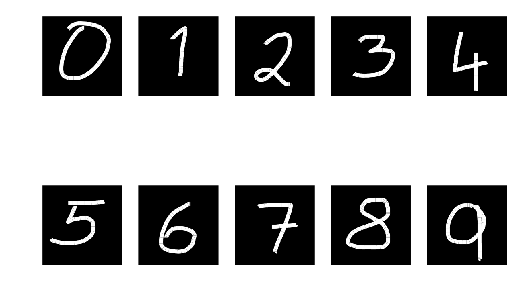

In [16]:
# Plot the example handwritten digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [17]:
digits = [prep.crop_img(digit) for digit in digits]

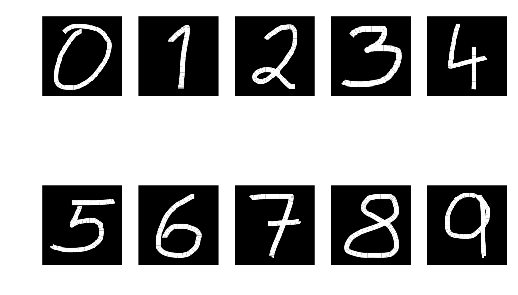

In [18]:
# Plot the cropped digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [19]:
digits = [prep.resize_img(digit) for digit in digits]

In [20]:
digits[0].shape

(28, 28)

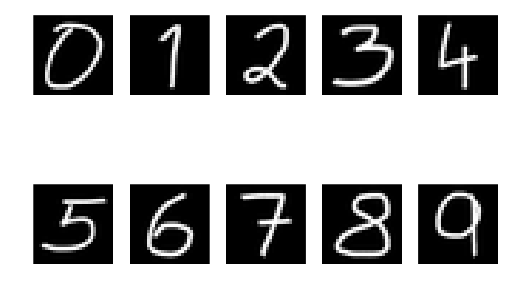

In [21]:
# Plot the cropped digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [22]:
digits = [prep.min_max_scaler(digit, final_range=(0, 1)) for digit in digits]

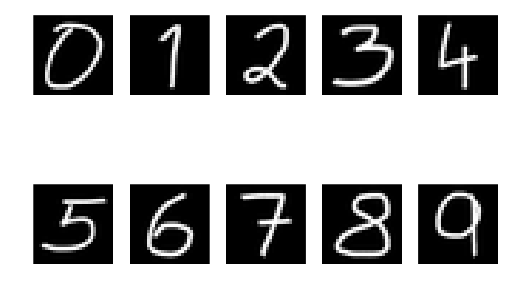

In [39]:
# Plot the min-max-scaled digits
for i, digit in enumerate(digits):
    plt.subplot(2, 5, i+1)
    plt.imshow(digit, cmap = 'gray', interpolation = 'none')
    plt.grid(True)
    plt.axis('off')

plt.show()

In [38]:
#digits = [prep.flatten_img(digit) for digit in digits]
digits[6].max()

1.0

In [24]:
#digits = [prep.flatten_img(digit) for digit in digits]
digits[4].shape

(28, 28)

In [27]:
# Load the tflearn pre-trained model
model = tflearn.DNN(cnn, tensorboard_verbose=0)
model.load('cnn.tflearn')

In [28]:
pred = {key: np.around(model.predict(np.reshape(value, (-1, 28, 28, 1), order='C')), 2)
        for (key, value) in enumerate(digits)}

In [29]:
pred

{0: array([[ 0.96,  0.  ,  0.02,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]),
 1: array([[ 0.  ,  0.3 ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.68,  0.  ,  0.  ]]),
 2: array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 3: array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 4: array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.99,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]]),
 5: array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]]),
 6: array([[ 0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.55,  0.32,  0.  ,  0.12,  0.  ]]),
 7: array([[ 0.  ,  0.  ,  0.  ,  0.12,  0.  ,  0.  ,  0.  ,  0.88,  0.  ,  0.  ]]),
 8: array([[ 0.  ,  0.  ,  0.27,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.72,  0.  ]]),
 9: array([[ 0.  ,  0.  ,  0.04,  0.  ,  0.17,  0.  ,  0.  ,  0.  ,  0.01,
          0.78]])}

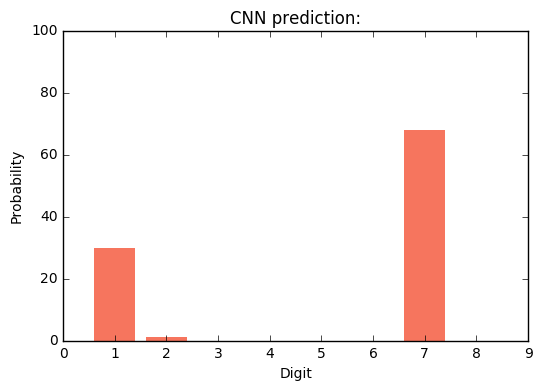

In [32]:
# Plot prediction
def prob_distribution_plot(pred):
    digit_labels = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
    x_pos = np.arange(len(digit_labels))
    prediction = pred.reshape([10]) * 100
    
    plt.bar(x_pos, prediction, align='center', color='#f6755e', edgecolor = "none")
    plt.xticks(x_pos, digit_labels)
    plt.ylim([0,100])
    plt.xlim([0,9])
    plt.ylabel('Probability')
    plt.xlabel('Digit')
    plt.title('CNN prediction:')
    
    plt.show()


prob_distribution_plot(np.around(model.predict(np.reshape(digits[1], (1, 28, 28, 1), order='C')), 2))

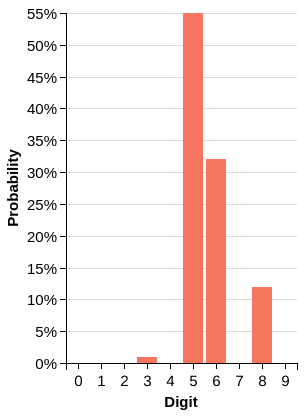

In [31]:
from altair import Chart, Data, X, Y, Axis

# Plot prediction
def prob_distribution_plot(pred):
    prediction = pred.reshape([10])
    data = Data(values=[{'x': i, 'y': value} for i, value in enumerate(prediction)])
    plot = Chart(data).mark_bar(color='#f6755e').encode(
        x=X('x:O', axis=Axis(title='Digit', labelAngle=0.5, tickLabelFontSize=15, titleFontSize=15)),
        y=Y('y:Q', axis=Axis(format='%', title='Probability', tickLabelFontSize=15, titleFontSize=15)))
    
    return plot

prob_distribution_plot(np.around(model.predict(np.reshape(digits[6], (1, 28, 28, 1), order='C')), 2))

In [33]:
from altair import Chart, Data, X, Y, Axis

# Plot prediction
def prob_distribution_plot(pred):
    prediction = pred.reshape([10])
    data = Data(values=[{'x': i, 'y': value} for i, value in enumerate(prediction)])
    plot = Chart(data).mark_bar(color='#f6755e').encode(
        x=X('x:O', axis=Axis(title='Digit', labelAngle=0.5, tickLabelFontSize=15, titleFontSize=15)),
        y=Y('y:Q', axis=Axis(format='%', title='Probability', tickLabelFontSize=15, titleFontSize=15)))
    
    return plot.to_json(indent=2)

prob_distribution_plot(np.around(model.predict(np.reshape(digits[6], (1, 28, 28, 1), order='C')), 2))

'{\n  "config": {\n    "mark": {\n      "color": "#f6755e"\n    }\n  },\n  "data": {\n    "values": [\n      {\n        "x": 0,\n        "y": 0.0\n      },\n      {\n        "x": 1,\n        "y": 0.0\n      },\n      {\n        "x": 2,\n        "y": 0.0\n      },\n      {\n        "x": 3,\n        "y": 0.01\n      },\n      {\n        "x": 4,\n        "y": 0.0\n      },\n      {\n        "x": 5,\n        "y": 0.55\n      },\n      {\n        "x": 6,\n        "y": 0.32\n      },\n      {\n        "x": 7,\n        "y": 0.0\n      },\n      {\n        "x": 8,\n        "y": 0.12\n      },\n      {\n        "x": 9,\n        "y": 0.0\n      }\n    ]\n  },\n  "encoding": {\n    "x": {\n      "axis": {\n        "labelAngle": 0.5,\n        "tickLabelFontSize": 15.0,\n        "title": "Digit",\n        "titleFontSize": 15.0\n      },\n      "field": "x",\n      "type": "ordinal"\n    },\n    "y": {\n      "axis": {\n        "format": "%",\n        "tickLabelFontSize": 15.0,\n        "title": "Pr

[Back to top](#Top)